In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sympy import *

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin

import plotly.plotly as py
import plotly.graph_objs as go

import modulesForCalibration_VG_XI as mfc
import readPlotOptionSurface_granular_typeXII as marketSurface 
import readPlotOptionSurface_o

## Market Prices

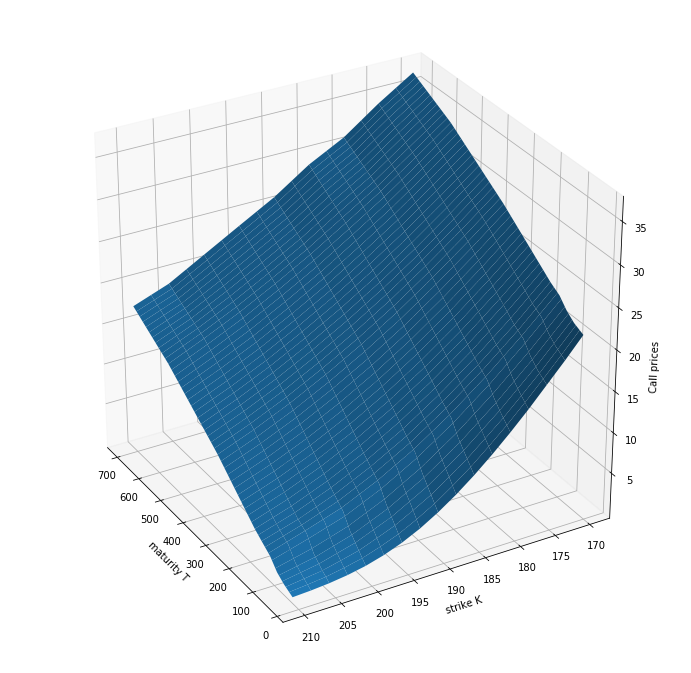

In [5]:
maturities, strikes, marketPrices, rC = marketSurface.readNPlot('APPL', 'Call')
maturities_years = maturities/365

### Contract specifications

In [6]:
T = 1  
r = 0.0541
q = 0.012

"""""APPL"""""
S = 190
K0 = 190
T = maturities_years[-1]

In [ ]:
"""""MSFT"""""
S = 190
K0 = 190
"""""AMZN"""""
S = 190
K0 = 190
"""""FB"""""
S = 190
K0 = 190

# Volatility Surface in functional form 

## I. Hyperpolynomial - 6 Params

In [354]:
def vol_function(strikes,K0,S0,maturities, params_vol):
    a = params_vol[0]
    b = params_vol[1]
    c = params_vol[2]
    d = params_vol[3]
    e = params_vol[4]
    nu = params_vol[5]
    
    """
    f = params_vol[5]
    g = params_vol[6]
    h = params_vol[7]
    """
    a = mfc.paramMapping(a  ,-1.0, 1.0)          
    b = mfc.paramMapping(b  ,-1.0, 1.0)       
    c = mfc.paramMapping(c  ,-1.0, 1.0)
    d = mfc.paramMapping(d  ,-1.0, 1.0)
    e = mfc.paramMapping(e  ,-1.0, 1.0)
    nu = mfc.paramMapping(nu  ,-1.0, 1.0)

    """
    f = mfc.paramMapping(f  ,-1.0, 1.0)
    g = mfc.paramMapping(g  ,-1.0, 1.0)
    h = mfc.paramMapping(h  ,-1.0, 1.0)
    """
    
    lenT = len(maturities)
    lenK = len(strikes)
    volSurface = np.zeros((lenT, lenK))
    #print(volSurface.shape)
    
    for i in range(lenT):
        for j in range(lenK):
            T = maturities[i]
            K = strikes[j]
            #volSurface[i,j] = (a*(K-K0) + b*T + c)
            volSurface[i,j] = ((a*np.log(K/S0)**4 + b*np.log(K/S0)**3 + c*np.log(K/S0)**2 + d*np.log(K/S0))*np.exp(1/((K/S0)*nu)*T) + e)
                              #((-0.00082347*x**4) + 0.00786172*x**3 -0.01582862*x**2 -0.01818996*x)*np.exp(-1.75) + 0.24224624 
    return volSurface
    #return np.exp(-nu*T)*(a*(K-K0)**3 + b*(K-K0)**2 + c*(K-K0) + d)

In [355]:
# Initial Parameter Set
params_vol = [-0.00082347,  0.00786172, -0.01582862, -0.01818996,  0.24224624, -1]

In [177]:
figV = py.get_figure("https://plot.ly/~friedrichz/431")

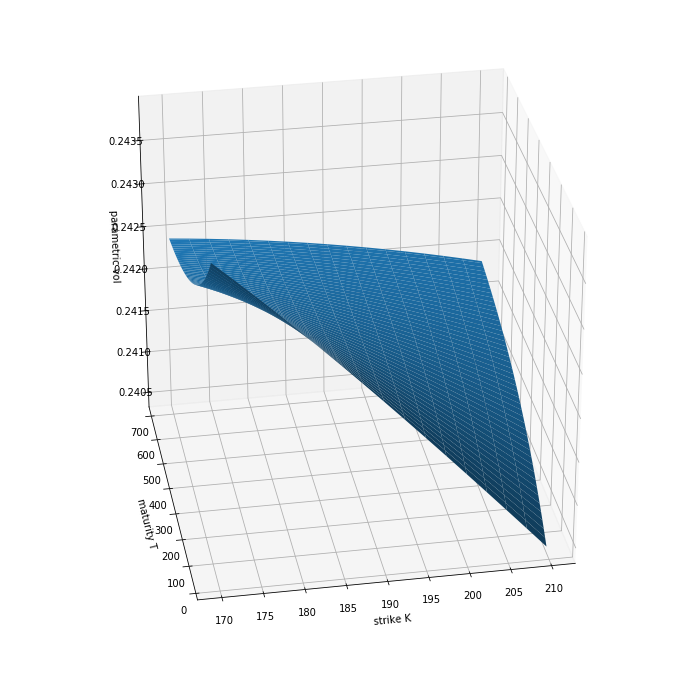

In [468]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,K0,S,maturities_years, params_vol))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
ax.view_init(30, 260)
plt.show()

## II. Polynomials + Exponentials - 14 Params

In [14]:
# 14 Parameters
initial_params_vol = [-0.5,-0.5,0.01,-0.5,-0.5,-0.99,-0.99, # T - Axis
                      100,0.035,0.1,178,1,-180.5,-1 ]       # K - Axis

In [8]:
def solve_quadratic(a, b, c):
    """
    Given three real coefficients,
    returns the (real) roots of the second degree polynomial
    """
    negative_b = -b
    determinant = b**2 - 4*a*c
    if a == 0.:
        return [float(-c)/b]
    else:
        root_determinant = cmath.sqrt(determinant)
        two_a = 2*a
        answers = [(negative_b - root_determinant)/two_a]
        if determinant:
            answers.append((negative_b + root_determinant)/two_a)
        return answers

In [7]:
def vol_function(strikes,maturities, params_vol, l1=195, l2=205,S0=190):
    x1 = np.log(l1/S0) # np.log(K0/S0) = 0.05 = np.log(190/180) roughly
    x2 = np.log(l2/S0) # np.log(210/180)
    ######### T-Axis PARAMETERS ############
    nu1 = params_vol[0]
    nu2 = params_vol[1]
    nu3 = params_vol[2]
    nu4 = params_vol[3]
    nu5 = params_vol[4]
    nu6 = params_vol[5]
    nu7 = params_vol[6]
    ######### SETUP SURFACE ############
    lenT = len(maturities)
    lenK = len(strikes)
    volSurface = np.zeros((lenT, lenK))
    for i in range(lenT):
        T = maturities[i]
        ######### K-Axis PARAMETERS ############ need to decay with time
        amr = params_vol[7] *np.exp(nu1*T)
        bmr = params_vol[8] *np.exp(nu2*T)                      #0.008 #0.005 -> Determines where the center will be !!
        cmr = params_vol[9] *np.exp(nu3*T)

        ar = params_vol[10] *np.exp(nu4*T)
        arr= params_vol[11] *np.exp(nu5*T)

        al = params_vol[12] *np.exp(nu6*T)
        a1l = params_vol[13] *np.exp(nu7*T)
        
        ######### DERIVED PARAMS #########
        # - #
        aml = amr 
        bml = -4*amr*x1+bmr
        cml = amr*x1**2-bmr*x1+cmr-aml*x1**2-bml*x1

        bl = aml
        cl = bml
        dl = cml

        # + #
        br = amr
        cr = bmr
        dr = cmr
        
        ######## EXP #########
        l_x2 =  al*(-x2+x1)**3 + bl*(-x2+x1)**2 + cl*(-x2+x1) + dl
        l1_x2 =  3*al*(-x2+x1)**2 + 2*bl*(-x2+x1) + cl
        l2_x2 =  6*al*(-x2+x1) + 2*bl  

        r_x2 =  ar*(x2-x1)**3 + br*(x2-x1)**2 + cr*(x2-x1) + dr
        r1_x2 =  3*ar*(x2-x1)**2 + 2*br*(x2-x1) + cr
        r2_x2 =  6*ar*(x2-x1) + 2*br
        
        c1l = solve_quadratic(l_x2,l1_x2,l2_x2)[0].real
        bll = (l_x2*a1l)/(l1_x2-l_x2*c1l)
        dll = (np.log(l_x2)-np.log(bll))/c1l

        crr = solve_quadratic(r_x2,r1_x2,r2_x2)[0].real
        brr = (r_x2*arr)/(r1_x2-r_x2*crr) 
        drr = (np.log(r_x2)-np.log(brr))/crr

        for j in range(lenK):
            x = np.log(strikes[j]/S0) 
            # -
            if (x >= -x1) and (x < 0):
                ml = aml*(x+x1)**2 + bml*(x+x1) + cml
                volSurface[i,j] = ml             
            elif (x >= -x2) and (x < -x1): 
                l = al*(x+x1)**3 + bl*(x+x1)**2 + cl*(x+x1) + dl
                volSurface[i,j] = l         
            elif (x < -x2): 
                ll = (a1l*(x+x2)+bll)*np.exp(c1l*((x+x2)+dll))
                volSurface[i,j] = ll
            # +
            elif (x <= x1) and (x >= 0):
                mr = amr*(x-x1)**2 + bmr*(x-x1) + cmr
                volSurface[i,j] = mr
            elif (x <= x2) and (x > x1):
                r = ar*(x-x1)**3 + br*(x-x1)**2 + cr*(x-x1) + dr
                volSurface[i,j] = r 
            elif (x > x2):
                rr = (arr*(x-x2)+brr)*np.exp(crr*((x-x2) + drr))
                volSurface[i,j] = rr
            else:
                volSurface[i,j] = 0
    return volSurface      

** ParamVol Starting Point I **

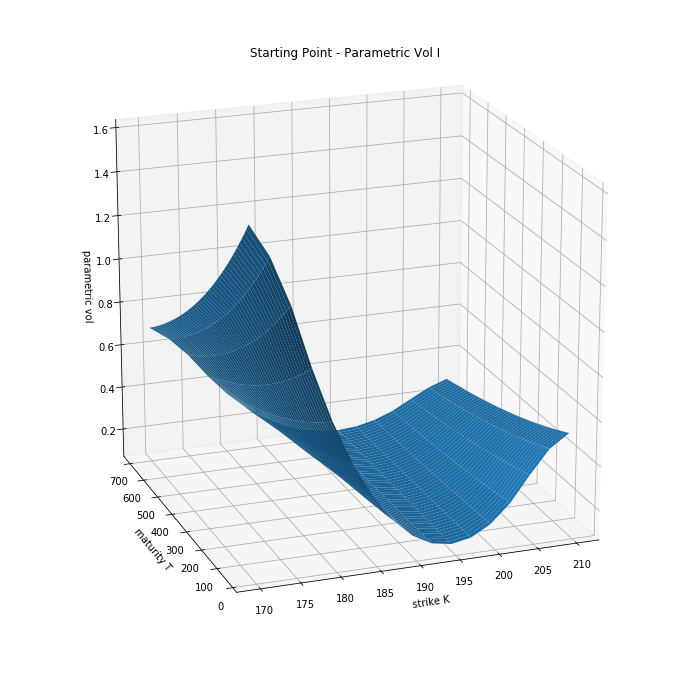

In [15]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,maturities/365, initial_params_vol))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
plt.title('Starting Point - Parametric Vol I')
plt.savefig('StartingPointParametricI.png')
ax.view_init(20, 250)
plt.show()

** ParamVol Starting Point II **

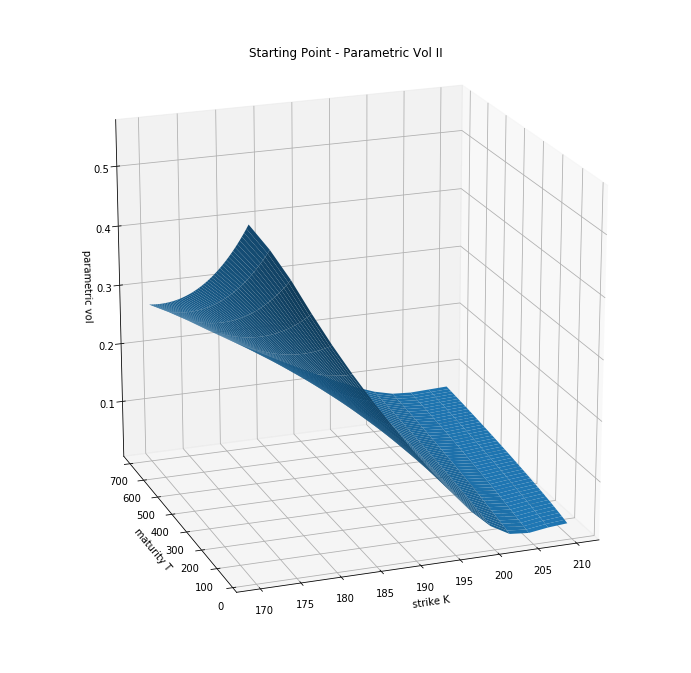

In [12]:
params1 = [-0.8,-0.5,0.01,-0.5,-0.5,-0.99,-0.99,            
            5,-3,0.1,400,1,-30.5,-1.4 ] 

fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,maturities/365, params1))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
plt.title('Starting Point - Parametric Vol II')
plt.savefig('StartingPointParametricII.png')
ax.view_init(20, 250)
plt.show()

## I. Solve Forward PDE via Finite Differences

 **Implicit scheme**

In [13]:
def tridiagSolver(l, d, u, f):
    ''' Tridiagonal solver '''
    n = len(f)
    v = np.zeros(n)
    y = np.zeros(n)
    w = d[0]
    y[0] = 1. * f[0] / w
    for i in range(1, n):
        v[i-1] = 1. * u[i-1] / w
        w = d[i] - l[i] * v[i-1]
        y[i] = 1. * (f[i] - l[i] * y[i-1]) / w
    for j in range(n-2, -1, -1):
        y[j] = y[j] - v[j] * y[j+1]
    return y

In [283]:
# BS forward PDE
def finite_diff(params_vol, maturities, strikes, S, K0):
    r = 0.0541
    q = 0.012
    maturities_years = maturities/365
    T = maturities_years[-1]
    
    # 0,1,2,...,N,N+1
    kMin = min(strikes)
    kMax = max(strikes)

    N = len(strikes)-1  # There is one "Box" less than number of strikes on x-Axis
    M = len(maturities) #96

    dK = (kMax - kMin) / (len(strikes)-1) # 2.5
    dT = 7/365                            

    # Need to switch the fixed parameters now: S becomes fixed & K is my x-axis ==> LEAVE OUT BOUNDARIES
    k = strikes[1:-1]
    tau = maturities_years

    l = np.zeros(N-1)    # Lenght is 15 -> not including boundaries!
    u = np.zeros(N-1)
    d = np.zeros(N-1)
    
    vCall = np.zeros(N-1)
    
    alpha = 0.5 * dT / (dK ** 2)     # taking (sig ** 2) out because different on each T;K grid point 
    beta = (r - q) * dT / (2.0 * dK)
 
    vCall = np.maximum(S - k,0)   # Initial condition -> Risk-neutral pricing / Excl. Boundaries !!
    modelPrices = np.zeros((len(tau), len(strikes)))
    vCall_wB = np.insert(vCall,0,S-kMax)
    vCall_wB = np.append(vCall_wB,S-kMin)
    modelPrices[0] = vCall_wB       # Init Cond at tau = 0
    # For each time slice compute Option Prices via Implicit scheme across all strikes (as opposed to stock prices)
    # And with vol function with fixed T across all strikes -> time slice 2 dim
    # Reference point is x_j,i+1 -> thus need sig_j,i+1 at each point (!)
    for j in range(M):
        t = tau[j]                                                              # The only diff to before is that now sigma is dependend on maturity and strike, thus I need to update the tridiagonal matrix in each run   
        # tridiagonal matrix: Need to do Dirichlet                              # Thus calc vol for all strikes and fixed maturity   
        l = (-alpha * (k ** 2) * vol_function(k,[t],params_vol)[0] + beta * k)  # implicit scheme l_hat -> already setting up the entire(!) diagonal
        l[0] = 0                                                                        # l & u are by one row shorter than d
        d = (1 + r * dT + 2 * alpha*vol_function(k,[t],params_vol)[0] * (k ** 2))  # because output of vol_function is matrix
        u = (-alpha*vol_function(k,[t],params_vol)[0] * (k ** 2) - beta * k)
        u[-1] = 0
        
        tmp_pay_Max = np.maximum(S - kMax*np.exp(-r*t),0)                    # Because under R-N measure PV & EV of Stock cancel out
        vCall[-1] -= tmp_pay_Max * (-alpha * vol_function([kMax],[t],params_vol)[0] * (kMax ** 2) - beta * kMax)   
        
        tmp_pay_Min = np.maximum(S - kMin*np.exp(-r*t),0)
        vCall[0] -= tmp_pay_Min * (-alpha * vol_function([kMin],[t],params_vol)[0] * (kMin ** 2) + beta * kMin)
        
        vCall = tridiagSolver(l, d, u, vCall)    # solve for vk+1´s in current time slice for european options
        vCall_wB = np.insert(vCall,0,tmp_pay_Min)
        vCall_wB = np.insert(vCall_wB,-1,tmp_pay_Max)
        modelPrices[j] = vCall_wB
        #modelPrices[j].append(np.maximum(S - kMax*np.exp(-q*dT*j),0))
        #print(modelPrices[j])
    return modelPrices[5:,1:-2]

***Test if FD is working***

In [284]:
testPrices = finite_diff(initial_params_vol, maturities, strikes, 190, 190)

In [230]:
#testPrices[5:,1:-2], maturities[5:], strikes[1:-2]

## II. Solve Model Prices via BS Closed Form

In [9]:
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

def bsSurface(params_vol, maturities, strikes, s):
    r = 0.0541
    q = 0.012
    maturities_years = maturities/365
    vol = vol_function(strikes,maturities_years,params_vol)
    lenT = len(maturities)
    lenK = len(strikes)
    bsPrices = np.zeros((lenT, lenK))
    if bsPrices.shape != vol.shape:
        print('Shape missmatch')
    else:
        for i in range(lenT):
            for j in range(lenK):
                T = maturities_years[i]
                K = strikes[j]
                sig = vol[i,j]
                bsPrices[i,j] = BS_price('call',s,K,r,q,sig,T)
    return bsPrices

In [10]:
BS_price('call',190,210,r,q,0.02,0.05)

4.355095130639989e-108

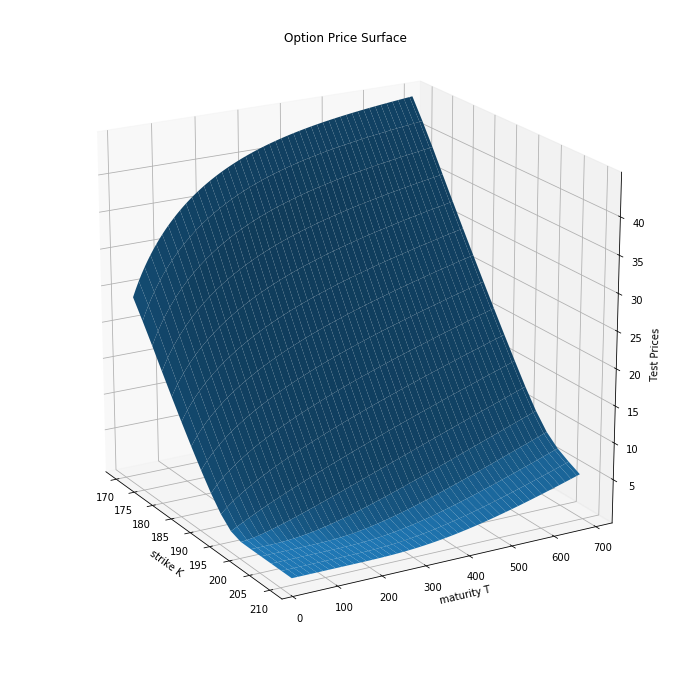

In [524]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, bsSurface(params1, maturities, strikes, S))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Test Prices')
plt.title('Option Price Surface\n')
ax.view_init(20, 330)
plt.show()

## III. Solve Model Prices via FFT

In [18]:
model = 'GBM'
paramsFFT = [3.0, 0.06, 0.1, -0.6, 0.04]

In [19]:
def FFTprices(S,K,strikes,maturities, paramsVOL):
    alpha = 1.5                     
    eta = 0.2
    n = 10
    N = 2**n
    r = 0.0541
    q = 0.012

    lenT = len(maturities)
    lenK = len(strikes)
    maturities_years = maturities/365
    FFTprices = np.zeros((lenT, lenK))
    vol = vol_function(strikes,maturities_years,paramsVOL)

    for i in range(lenT):
        for j in range(lenK):
            T = maturities_years[i]
            K = strikes[j]
            sig = vol[i,j]
            [km, cT_km] = mfc.genericFFT([sig],S, K, r, q, T, alpha, eta, n, 'GBM')
            FFTprices[i,j] = cT_km[0]
    return FFTprices

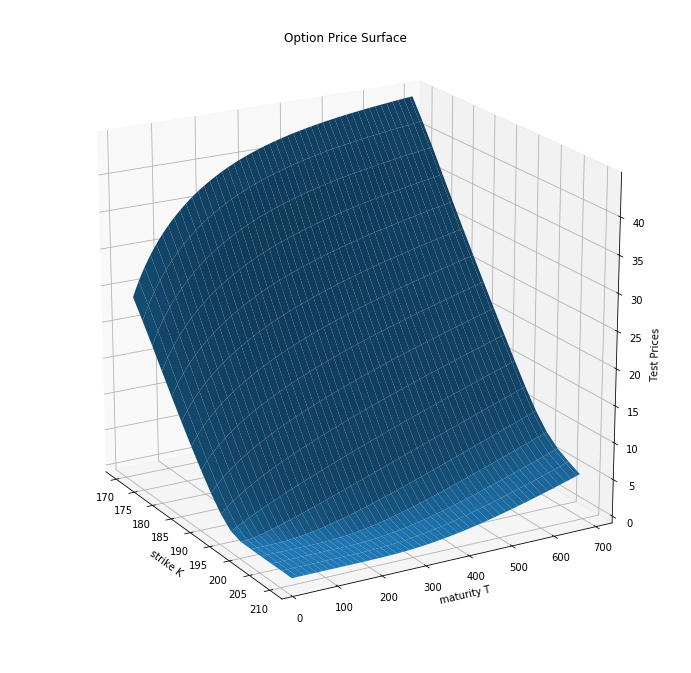

In [557]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, FFTprices(S,K0,strikes,maturities, params1))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Test Prices')
plt.title('Option Price Surface\n')
ax.view_init(20, 330)
plt.show()

# Optimizer

## I. Objective Function

In [506]:
# SSE
# def eValue(params, marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model):
def eValue(params, *args):
    
    marketPrices = args[0].transpose()
    maturities = args[1]
    strikes = args[2]
    S = args[3]
    K0 = args[4]
    
    lenT = len(maturities)
    lenK = len(strikes)
    
    count = 0
    mae = 0
    modelPrices = bsSurface(params, maturities, strikes, S) #finite_diff(params, maturities, strikes, S, K0)
    rmse = (np.sum((marketPrices - modelPrices)**2) / (lenT*lenK))**0.5
    return rmse

In [525]:
eValue(params1, marketPrices, maturities, strikes, S, K0)

7.113875002546263

## II. Finding a starting point

In [541]:
params1 = [-0.8,-0.5,0.01,-0.5,-0.5,-0.99,-0.99,            
            5,-3,0.1,400,1,-30.5,-1.4 ] 

params2 = [ 7.45526310e-01,  1.03560849e+00, -5.74431669e-03,  4.87995557e+00,
 -3.94346457e+00 ,-1.35594994e+00 ,-5.16538443e+00 , 6.76587834e-02,
  1.14499685e-02 , 1.90218653e-01 ,-2.90285024e-03 , 1.97487093e+00,
 -4.29560540e+01 ,-7.25453239e+00]

In [544]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10 

for i in np.arange(-5,1,0.1):  #mfc.myRange
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
    rmse = eValue(params, marketPrices, maturities, strikes, S, K0)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params
len(rmseArray) == len(iArray)

True

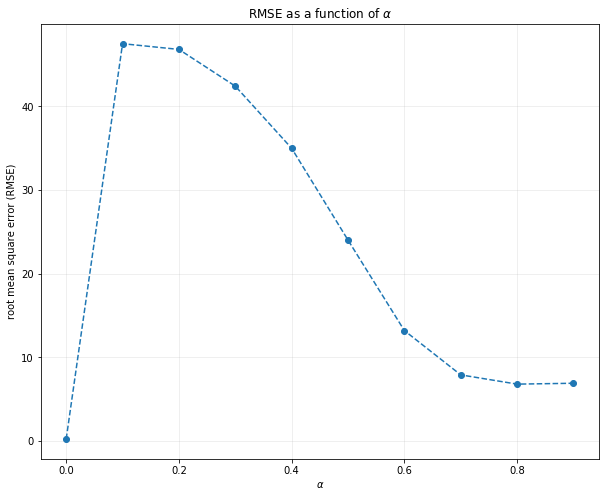

0.23860197923546175
[ 7.45526310e-01  1.03560849e+00 -5.74431669e-03  4.87995557e+00
 -3.94346457e+00 -1.35594994e+00 -5.16538443e+00  6.76587834e-02
  1.14499685e-02  1.90218653e-01 -2.90285025e-03  1.97487093e+00
 -4.29560540e+01 -7.25453239e+00]


In [545]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('startingPoint4.png')
plt.show()

print(rmseMin)
print(optimParams)

## III. Choice of Optimization Algorithm

In [529]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================
params = params1 #initial_params_vol
#params = para
def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, S, K0)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=10000,
        maxfun=20000,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [-8.08571429e-01 -5.05357143e-01  1.01071429e-02 -5.05357143e-01
 -5.05357143e-01 -1.00060714e+00 -1.00060714e+00  5.05357143e+00
 -2.70000000e+00  1.01071429e-01  4.04285714e+02  1.01071429e+00
 -3.08267857e+01 -1.41500000e+00]
f_i = 6.548454057906108
i = 2
x_i = [-8.08571429e-01 -5.05357143e-01  1.01071429e-02 -5.05357143e-01
 -5.05357143e-01 -1.00060714e+00 -1.00060714e+00  5.05357143e+00
 -2.70000000e+00  1.01071429e-01  4.04285714e+02  1.01071429e+00
 -3.08267857e+01 -1.41500000e+00]
f_i = 6.548454057906108
i = 3
x_i = [-8.08571429e-01 -5.05357143e-01  1.01071429e-02 -5.05357143e-01
 -5.05357143e-01 -1.00060714e+00 -1.00060714e+00  5.05357143e+00
 -2.70000000e+00  1.01071429e-01  4.04285714e+02  1.01071429e+00
 -3.08267857e+01 -1.41500000e+00]
f_i = 6.548454057906108
i = 4
x_i = [-8.08571429e-01 -5.05357143e-01  1.01071429e-02 -5.05357143e-01
 -5.05357143e-01 -1.00060714e+00 -1.00060714e+00  5.05357143e+00
 -2.70000000e+00  1.01071429e-01  4.04285714e+02  1.01071429e+0

f_i = 5.230406788212683
i = 32
x_i = [-8.50221307e-01 -5.52321184e-01  1.02793392e-02 -5.14931718e-01
 -4.95669459e-01 -1.03521073e+00 -1.00918729e+00  4.74409066e+00
 -2.20445773e+00  1.11328654e-01  4.29407168e+02  9.74226042e-01
 -2.90388726e+01 -1.34664206e+00]
f_i = 5.230406788212683
i = 33
x_i = [-8.50221307e-01 -5.52321184e-01  1.02793392e-02 -5.14931718e-01
 -4.95669459e-01 -1.03521073e+00 -1.00918729e+00  4.74409066e+00
 -2.20445773e+00  1.11328654e-01  4.29407168e+02  9.74226042e-01
 -2.90388726e+01 -1.34664206e+00]
f_i = 5.230406788212683
i = 34
x_i = [-8.50221307e-01 -5.52321184e-01  1.02793392e-02 -5.14931718e-01
 -4.95669459e-01 -1.03521073e+00 -1.00918729e+00  4.74409066e+00
 -2.20445773e+00  1.11328654e-01  4.29407168e+02  9.74226042e-01
 -2.90388726e+01 -1.34664206e+00]
f_i = 5.230406788212683
i = 35
x_i = [-8.50221307e-01 -5.52321184e-01  1.02793392e-02 -5.14931718e-01
 -4.95669459e-01 -1.03521073e+00 -1.00918729e+00  4.74409066e+00
 -2.20445773e+00  1.11328654e-01  4

f_i = 2.0523083832601685
i = 63
x_i = [-9.51385077e-01 -5.79687277e-01  9.47699288e-03 -6.31049289e-01
 -4.49777802e-01 -1.14283968e+00 -1.18512187e+00  4.46904442e+00
 -2.53948261e-01  1.45439167e-01  4.70350801e+02  9.49696248e-01
 -2.35108514e+01 -1.31968274e+00]
f_i = 2.0523083832601685
i = 64
x_i = [-9.51385077e-01 -5.79687277e-01  9.47699288e-03 -6.31049289e-01
 -4.49777802e-01 -1.14283968e+00 -1.18512187e+00  4.46904442e+00
 -2.53948261e-01  1.45439167e-01  4.70350801e+02  9.49696248e-01
 -2.35108514e+01 -1.31968274e+00]
f_i = 2.0523083832601685
i = 65
x_i = [-9.51385077e-01 -5.79687277e-01  9.47699288e-03 -6.31049289e-01
 -4.49777802e-01 -1.14283968e+00 -1.18512187e+00  4.46904442e+00
 -2.53948261e-01  1.45439167e-01  4.70350801e+02  9.49696248e-01
 -2.35108514e+01 -1.31968274e+00]
f_i = 2.0523083832601685
i = 66
x_i = [-1.02074233e+00 -6.26271716e-01  9.70034391e-03 -6.47949024e-01
 -4.22994354e-01 -1.23181655e+00 -1.21507033e+00  3.92837200e+00
  1.27681230e-01  1.57883073e-0

f_i = 1.4694122847040116
i = 94
x_i = [-9.81354685e-01 -6.51078075e-01  9.65489973e-03 -7.16086543e-01
 -4.06731694e-01 -1.27239459e+00 -1.21489492e+00  3.86264947e+00
  1.04525260e-01  1.68620305e-01  4.97997144e+02  8.30946571e-01
 -1.93820449e+01 -1.04684853e+00]
f_i = 1.4694122847040116
i = 95
x_i = [-9.81354685e-01 -6.51078075e-01  9.65489973e-03 -7.16086543e-01
 -4.06731694e-01 -1.27239459e+00 -1.21489492e+00  3.86264947e+00
  1.04525260e-01  1.68620305e-01  4.97997144e+02  8.30946571e-01
 -1.93820449e+01 -1.04684853e+00]
f_i = 1.4694122847040116
i = 96
x_i = [-9.81354685e-01 -6.51078075e-01  9.65489973e-03 -7.16086543e-01
 -4.06731694e-01 -1.27239459e+00 -1.21489492e+00  3.86264947e+00
  1.04525260e-01  1.68620305e-01  4.97997144e+02  8.30946571e-01
 -1.93820449e+01 -1.04684853e+00]
f_i = 1.4694122847040116
i = 97
x_i = [-9.81354685e-01 -6.51078075e-01  9.65489973e-03 -7.16086543e-01
 -4.06731694e-01 -1.27239459e+00 -1.21489492e+00  3.86264947e+00
  1.04525260e-01  1.68620305e-0

f_i = 1.1974240151698994
i = 125
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 126
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 127
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 128
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.7331782

f_i = 1.1974240151698994
i = 156
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 157
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 158
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.73317827e-01  5.00845605e+02  7.73598943e-01
 -1.55469036e+01 -8.98387472e-01]
f_i = 1.1974240151698994
i = 159
x_i = [-1.01189131e+00 -6.91694131e-01  1.02833675e-02 -7.95796578e-01
 -3.75405558e-01 -1.26506300e+00 -1.10324802e+00  3.53981876e+00
 -2.96474616e-01  1.7331782

f_i = 1.1531338007361305
i = 187
x_i = [-1.04452837e+00 -6.99155416e-01  1.03117438e-02 -8.27973752e-01
 -3.65057550e-01 -1.26858206e+00 -1.07624453e+00  3.51928241e+00
 -3.14917580e-01  1.73272616e-01  4.91688754e+02  7.62412397e-01
 -1.52174280e+01 -8.70938969e-01]
f_i = 1.1531338007361305
i = 188
x_i = [-1.04452837e+00 -6.99155416e-01  1.03117438e-02 -8.27973752e-01
 -3.65057550e-01 -1.26858206e+00 -1.07624453e+00  3.51928241e+00
 -3.14917580e-01  1.73272616e-01  4.91688754e+02  7.62412397e-01
 -1.52174280e+01 -8.70938969e-01]
f_i = 1.1531338007361305
i = 189
x_i = [-1.07842347e+00 -7.10898987e-01  1.04986145e-02 -8.41390496e-01
 -3.57448537e-01 -1.28240544e+00 -1.05183719e+00  3.33802078e+00
 -2.18915835e-01  1.75528108e-01  4.99262182e+02  7.49357894e-01
 -1.44855333e+01 -8.21484533e-01]
f_i = 1.1425151332998356
i = 190
x_i = [-1.07842347e+00 -7.10898987e-01  1.04986145e-02 -8.41390496e-01
 -3.57448537e-01 -1.28240544e+00 -1.05183719e+00  3.33802078e+00
 -2.18915835e-01  1.7552810

f_i = 0.9897775080578466
i = 218
x_i = [-1.13773563e+00 -7.34330590e-01  1.12569420e-02 -9.04509365e-01
 -3.44567482e-01 -1.29147908e+00 -9.62162271e-01  3.03521259e+00
 -3.04062749e-01  1.73857833e-01  4.50078661e+02  7.45515094e-01
 -1.46317963e+01 -7.72260275e-01]
f_i = 0.9897775080578466
i = 219
x_i = [-1.17815004e+00 -7.58225214e-01  1.17898685e-02 -9.43410754e-01
 -3.44390097e-01 -1.33106961e+00 -9.05890056e-01  2.78374692e+00
 -2.82845771e-01  1.78242608e-01  4.30888539e+02  7.01720442e-01
 -1.31558518e+01 -6.81434332e-01]
f_i = 0.9447282799966015
i = 220
x_i = [-1.17815004e+00 -7.58225214e-01  1.17898685e-02 -9.43410754e-01
 -3.44390097e-01 -1.33106961e+00 -9.05890056e-01  2.78374692e+00
 -2.82845771e-01  1.78242608e-01  4.30888539e+02  7.01720442e-01
 -1.31558518e+01 -6.81434332e-01]
f_i = 0.9447282799966015
i = 221
x_i = [-1.17815004e+00 -7.58225214e-01  1.17898685e-02 -9.43410754e-01
 -3.44390097e-01 -1.33106961e+00 -9.05890056e-01  2.78374692e+00
 -2.82845771e-01  1.7824260

f_i = 0.4611438689178643
i = 249
x_i = [-1.39911420e+00 -8.96824858e-01  1.62850846e-02 -1.07812886e+00
 -3.56310559e-01 -1.53016289e+00 -5.47850568e-01  1.02856877e+00
 -1.44063899e-01  1.79744721e-01  2.04581062e+02  6.59371064e-01
 -1.12416771e+01 -4.61061716e-01]
f_i = 0.4611438689178643
i = 250
x_i = [-1.39911420e+00 -8.96824858e-01  1.62850846e-02 -1.07812886e+00
 -3.56310559e-01 -1.53016289e+00 -5.47850568e-01  1.02856877e+00
 -1.44063899e-01  1.79744721e-01  2.04581062e+02  6.59371064e-01
 -1.12416771e+01 -4.61061716e-01]
f_i = 0.4611438689178643
i = 251
x_i = [-1.39911420e+00 -8.96824858e-01  1.62850846e-02 -1.07812886e+00
 -3.56310559e-01 -1.53016289e+00 -5.47850568e-01  1.02856877e+00
 -1.44063899e-01  1.79744721e-01  2.04581062e+02  6.59371064e-01
 -1.12416771e+01 -4.61061716e-01]
f_i = 0.4611438689178643
i = 252
x_i = [-1.39911420e+00 -8.96824858e-01  1.62850846e-02 -1.07812886e+00
 -3.56310559e-01 -1.53016289e+00 -5.47850568e-01  1.02856877e+00
 -1.44063899e-01  1.7974472

f_i = 0.3288704147563557
i = 280
x_i = [-1.73298361e+00 -1.02901007e+00  1.93367783e-02 -1.36212381e+00
 -2.69004013e-01 -1.65539089e+00 -1.71686632e-01 -2.36971499e-01
 -2.74136104e-02  1.84143544e-01  8.31110070e+01  5.57004880e-01
 -6.39060561e+00 -8.86085448e-02]
f_i = 0.3288704147563557
i = 281
x_i = [-1.73298361e+00 -1.02901007e+00  1.93367783e-02 -1.36212381e+00
 -2.69004013e-01 -1.65539089e+00 -1.71686632e-01 -2.36971499e-01
 -2.74136104e-02  1.84143544e-01  8.31110070e+01  5.57004880e-01
 -6.39060561e+00 -8.86085448e-02]
f_i = 0.3288704147563557
i = 282
x_i = [-1.73298361e+00 -1.02901007e+00  1.93367783e-02 -1.36212381e+00
 -2.69004013e-01 -1.65539089e+00 -1.71686632e-01 -2.36971499e-01
 -2.74136104e-02  1.84143544e-01  8.31110070e+01  5.57004880e-01
 -6.39060561e+00 -8.86085448e-02]
f_i = 0.3288704147563557
i = 283
x_i = [-1.73298361e+00 -1.02901007e+00  1.93367783e-02 -1.36212381e+00
 -2.69004013e-01 -1.65539089e+00 -1.71686632e-01 -2.36971499e-01
 -2.74136104e-02  1.8414354

f_i = 0.3234742670238128
i = 311
x_i = [-1.78734425e+00 -1.04496215e+00  1.95764234e-02 -1.38495796e+00
 -2.64358567e-01 -1.69445855e+00 -1.10266761e-01 -3.09350491e-01
 -3.23065898e-02  1.83380723e-01  7.68327121e+01  5.33046870e-01
 -5.39481773e+00 -3.54755781e-02]
f_i = 0.3234742670238128
i = 312
x_i = [-1.78734425e+00 -1.04496215e+00  1.95764234e-02 -1.38495796e+00
 -2.64358567e-01 -1.69445855e+00 -1.10266761e-01 -3.09350491e-01
 -3.23065898e-02  1.83380723e-01  7.68327121e+01  5.33046870e-01
 -5.39481773e+00 -3.54755781e-02]
f_i = 0.3234742670238128
i = 313
x_i = [-1.78734425e+00 -1.04496215e+00  1.95764234e-02 -1.38495796e+00
 -2.64358567e-01 -1.69445855e+00 -1.10266761e-01 -3.09350491e-01
 -3.23065898e-02  1.83380723e-01  7.68327121e+01  5.33046870e-01
 -5.39481773e+00 -3.54755781e-02]
f_i = 0.3234742670238128
i = 314
x_i = [-1.78734425e+00 -1.04496215e+00  1.95764234e-02 -1.38495796e+00
 -2.64358567e-01 -1.69445855e+00 -1.10266761e-01 -3.09350491e-01
 -3.23065898e-02  1.8338072

f_i = 0.3227886654768767
i = 342
x_i = [-1.76398887e+00 -1.04473807e+00  1.97622177e-02 -1.36853043e+00
 -2.75966948e-01 -1.69677931e+00 -1.19025446e-01 -3.62828325e-01
 -3.56023450e-02  1.83466189e-01  6.38558872e+01  5.41760316e-01
 -5.75741547e+00 -5.66932449e-02]
f_i = 0.3227886654768767
i = 343
x_i = [-1.76398887e+00 -1.04473807e+00  1.97622177e-02 -1.36853043e+00
 -2.75966948e-01 -1.69677931e+00 -1.19025446e-01 -3.62828325e-01
 -3.56023450e-02  1.83466189e-01  6.38558872e+01  5.41760316e-01
 -5.75741547e+00 -5.66932449e-02]
f_i = 0.3227886654768767
i = 344
x_i = [-1.76398887e+00 -1.04473807e+00  1.97622177e-02 -1.36853043e+00
 -2.75966948e-01 -1.69677931e+00 -1.19025446e-01 -3.62828325e-01
 -3.56023450e-02  1.83466189e-01  6.38558872e+01  5.41760316e-01
 -5.75741547e+00 -5.66932449e-02]
f_i = 0.3227886654768767
i = 345
x_i = [-1.76398887e+00 -1.04473807e+00  1.97622177e-02 -1.36853043e+00
 -2.75966948e-01 -1.69677931e+00 -1.19025446e-01 -3.62828325e-01
 -3.56023450e-02  1.8346618

f_i = 0.3217792751373173
i = 373
x_i = [-1.72335966e+00 -1.03554331e+00  1.96122110e-02 -1.32999492e+00
 -2.91986233e-01 -1.69749542e+00 -1.59221979e-01 -2.63481178e-01
 -2.71695645e-02  1.83531479e-01  6.51868405e+01  5.51060942e-01
 -6.17545693e+00 -9.92466071e-02]
f_i = 0.3217792751373173
i = 374
x_i = [-1.72335966e+00 -1.03554331e+00  1.96122110e-02 -1.32999492e+00
 -2.91986233e-01 -1.69749542e+00 -1.59221979e-01 -2.63481178e-01
 -2.71695645e-02  1.83531479e-01  6.51868405e+01  5.51060942e-01
 -6.17545693e+00 -9.92466071e-02]
f_i = 0.3217792751373173
i = 375
x_i = [-1.70512262e+00 -1.03118452e+00  1.96162941e-02 -1.31524641e+00
 -2.99736373e-01 -1.69189590e+00 -1.76085120e-01 -2.66786578e-01
 -2.05662179e-02  1.83634834e-01  6.22874778e+01  5.59294247e-01
 -6.52262072e+00 -1.19441149e-01]
f_i = 0.32144358994285205
i = 376
x_i = [-1.70512262e+00 -1.03118452e+00  1.96162941e-02 -1.31524641e+00
 -2.99736373e-01 -1.69189590e+00 -1.76085120e-01 -2.66786578e-01
 -2.05662179e-02  1.836348

f_i = 0.3186567073051415
i = 404
x_i = [-1.57328215e+00 -1.00834925e+00  1.95418933e-02 -1.19752380e+00
 -3.56103442e-01 -1.69829196e+00 -2.82073703e-01 -1.09353285e-01
 -1.04795179e-02  1.83544135e-01  4.62092901e+01  5.96182711e-01
 -8.11356972e+00 -2.55066017e-01]
f_i = 0.3186567073051415
i = 405
x_i = [-1.57328215e+00 -1.00834925e+00  1.95418933e-02 -1.19752380e+00
 -3.56103442e-01 -1.69829196e+00 -2.82073703e-01 -1.09353285e-01
 -1.04795179e-02  1.83544135e-01  4.62092901e+01  5.96182711e-01
 -8.11356972e+00 -2.55066017e-01]
f_i = 0.3186567073051415
i = 406
x_i = [-1.57328215e+00 -1.00834925e+00  1.95418933e-02 -1.19752380e+00
 -3.56103442e-01 -1.69829196e+00 -2.82073703e-01 -1.09353285e-01
 -1.04795179e-02  1.83544135e-01  4.62092901e+01  5.96182711e-01
 -8.11356972e+00 -2.55066017e-01]
f_i = 0.3186567073051415
i = 407
x_i = [-1.49497535e+00 -9.93755140e-01  1.94828234e-02 -1.13376049e+00
 -3.85903781e-01 -1.69205515e+00 -3.47026071e-01 -3.73475639e-02
 -4.33335976e-03  1.8361378

f_i = 0.31530701253318083
i = 436
x_i = [ -1.23261237  -0.94297867   0.01918969  -0.89917915  -0.49598885
  -1.68826877  -0.57390376   0.28708423   0.04439934   0.18385148
  14.37956725   0.69953583 -12.58784972  -0.61032139]
f_i = 0.31530701253318083
i = 437
x_i = [ -1.23261237  -0.94297867   0.01918969  -0.89917915  -0.49598885
  -1.68826877  -0.57390376   0.28708423   0.04439934   0.18385148
  14.37956725   0.69953583 -12.58784972  -0.61032139]
f_i = 0.31530701253318083
i = 438
x_i = [ -1.23261237  -0.94297867   0.01918969  -0.89917915  -0.49598885
  -1.68826877  -0.57390376   0.28708423   0.04439934   0.18385148
  14.37956725   0.69953583 -12.58784972  -0.61032139]
f_i = 0.31530701253318083
i = 439
x_i = [ -1.23261237  -0.94297867   0.01918969  -0.89917915  -0.49598885
  -1.68826877  -0.57390376   0.28708423   0.04439934   0.18385148
  14.37956725   0.69953583 -12.58784972  -0.61032139]
f_i = 0.31530701253318083
i = 440
x_i = [ -1.23261237  -0.94297867   0.01918969  -0.89917915  -0

f_i = 0.3151159854960541
i = 473
x_i = [ -1.24466472  -0.94749044   0.01925893  -0.90969774  -0.49176191
  -1.69482549  -0.56036531   0.26816928   0.04192873   0.18390274
  11.95702772   0.69376715 -12.34207238  -0.59538215]
f_i = 0.3151159854960541
i = 474
x_i = [ -1.24466472  -0.94749044   0.01925893  -0.90969774  -0.49176191
  -1.69482549  -0.56036531   0.26816928   0.04192873   0.18390274
  11.95702772   0.69376715 -12.34207238  -0.59538215]
f_i = 0.3151159854960541
i = 475
x_i = [ -1.24466472  -0.94749044   0.01925893  -0.90969774  -0.49176191
  -1.69482549  -0.56036531   0.26816928   0.04192873   0.18390274
  11.95702772   0.69376715 -12.34207238  -0.59538215]
f_i = 0.3151159854960541
i = 476
x_i = [ -1.24466472  -0.94749044   0.01925893  -0.90969774  -0.49176191
  -1.69482549  -0.56036531   0.26816928   0.04192873   0.18390274
  11.95702772   0.69376715 -12.34207238  -0.59538215]
f_i = 0.3151159854960541
i = 477
x_i = [ -1.24466472  -0.94749044   0.01925893  -0.90969774  -0.4917

f_i = 0.3151087375447995
i = 510
x_i = [ -1.23565965  -0.94566715   0.01925353  -0.90246368  -0.49537153
  -1.69322955  -0.5677689    0.27270084   0.04213816   0.1839212
  11.0157849    0.69690247 -12.48088414  -0.6045817 ]
f_i = 0.31510310329208374
i = 511
x_i = [ -1.23565965  -0.94566715   0.01925353  -0.90246368  -0.49537153
  -1.69322955  -0.5677689    0.27270084   0.04213816   0.1839212
  11.0157849    0.69690247 -12.48088414  -0.6045817 ]
f_i = 0.31510310329208374
i = 512
x_i = [ -1.23565965  -0.94566715   0.01925353  -0.90246368  -0.49537153
  -1.69322955  -0.5677689    0.27270084   0.04213816   0.1839212
  11.0157849    0.69690247 -12.48088414  -0.6045817 ]
f_i = 0.31510310329208374
i = 513
x_i = [ -1.23565965  -0.94566715   0.01925353  -0.90246368  -0.49537153
  -1.69322955  -0.5677689    0.27270084   0.04213816   0.1839212
  11.0157849    0.69690247 -12.48088414  -0.6045817 ]
f_i = 0.31510310329208374
i = 514
x_i = [ -1.23565965  -0.94566715   0.01925353  -0.90246368  -0.4953

f_i = 0.315059036321506
i = 547
x_i = [ -1.24863476  -0.9476923    0.01925882  -0.91042304  -0.49230166
  -1.69642682  -0.55768486   0.26070743   0.03778496   0.1839172
  11.59429361   0.69202609 -12.25593278  -0.59336757]
f_i = 0.3150425713962561
i = 548
x_i = [ -1.24863476  -0.9476923    0.01925882  -0.91042304  -0.49230166
  -1.69642682  -0.55768486   0.26070743   0.03778496   0.1839172
  11.59429361   0.69202609 -12.25593278  -0.59336757]
f_i = 0.3150425713962561
i = 549
x_i = [ -1.24863476  -0.9476923    0.01925882  -0.91042304  -0.49230166
  -1.69642682  -0.55768486   0.26070743   0.03778496   0.1839172
  11.59429361   0.69202609 -12.25593278  -0.59336757]
f_i = 0.3150425713962561
i = 550
x_i = [ -1.23561063  -0.94484003   0.01925029  -0.89822922  -0.49835857
  -1.6949944   -0.56933635   0.26885024   0.04191847   0.18393153
  10.1294209    0.696905   -12.45979398  -0.60822191]
f_i = 0.31502344307686425
i = 551
x_i = [ -1.23561063  -0.94484003   0.01925029  -0.89822922  -0.4983585

f_i = 0.31478084144390905
i = 584
x_i = [ -1.23090119  -0.94009458   0.0191702   -0.87870649  -0.50928388
  -1.70127877  -0.58256039   0.29002232   0.04643689   0.183975
   9.8954044    0.69760013 -12.41024197  -0.62635414]
f_i = 0.31478084144390905
i = 585
x_i = [ -1.23090119  -0.94009458   0.0191702   -0.87870649  -0.50928388
  -1.70127877  -0.58256039   0.29002232   0.04643689   0.183975
   9.8954044    0.69760013 -12.41024197  -0.62635414]
f_i = 0.31478084144390905
i = 586
x_i = [ -1.23090119  -0.94009458   0.0191702   -0.87870649  -0.50928388
  -1.70127877  -0.58256039   0.29002232   0.04643689   0.183975
   9.8954044    0.69760013 -12.41024197  -0.62635414]
f_i = 0.31478084144390905
i = 587
x_i = [ -1.25298108  -0.94401584   0.0191911   -0.89723153  -0.50100533
  -1.7024631   -0.56374397   0.26243672   0.03924696   0.18392593
  11.41676939   0.69083096 -12.11271433  -0.60472676]
f_i = 0.31470037616307417
i = 588
x_i = [ -1.25298108  -0.94401584   0.0191911   -0.89723153  -0.50100

f_i = 0.31373595868427845
i = 621
x_i = [ -1.21036829  -0.91436954   0.01882229  -0.79995013  -0.55703551
  -1.70464641  -0.64088972   0.29579027   0.04234066   0.1841269
   9.28601573   0.70972155 -12.57709167  -0.71195012]
f_i = 0.313482884657049
i = 622
x_i = [ -1.21036829  -0.91436954   0.01882229  -0.79995013  -0.55703551
  -1.70464641  -0.64088972   0.29579027   0.04234066   0.1841269
   9.28601573   0.70972155 -12.57709167  -0.71195012]
f_i = 0.313482884657049
i = 623
x_i = [ -1.21036829  -0.91436954   0.01882229  -0.79995013  -0.55703551
  -1.70464641  -0.64088972   0.29579027   0.04234066   0.1841269
   9.28601573   0.70972155 -12.57709167  -0.71195012]
f_i = 0.313482884657049
i = 624
x_i = [ -1.21036829  -0.91436954   0.01882229  -0.79995013  -0.55703551
  -1.70464641  -0.64088972   0.29579027   0.04234066   0.1841269
   9.28601573   0.70972155 -12.57709167  -0.71195012]
f_i = 0.313482884657049
i = 625
x_i = [ -1.20149345  -0.90526665   0.01869415  -0.77559252  -0.57063301
  

f_i = 0.30889711341382786
i = 658
x_i = [ -1.00514998  -0.78382286   0.01726501  -0.3883587   -0.79073286
  -1.68520115  -0.98343404   0.42092646   0.06084639   0.18454674
   2.23666668   0.80907136 -15.46935174  -1.18610985]
f_i = 0.30889711341382786
i = 659
x_i = [ -1.00514998  -0.78382286   0.01726501  -0.3883587   -0.79073286
  -1.68520115  -0.98343404   0.42092646   0.06084639   0.18454674
   2.23666668   0.80907136 -15.46935174  -1.18610985]
f_i = 0.30889711341382786
i = 660
x_i = [-9.08441594e-01 -7.34837966e-01  1.67107447e-02 -2.22414488e-01
 -8.82986946e-01 -1.68255778e+00 -1.12134947e+00  5.00826414e-01
  6.97635797e-02  1.84695135e-01 -3.14576657e+00  8.49140092e-01
 -1.67241922e+01 -1.37449497e+00]
f_i = 0.3074509086731471
i = 661
x_i = [-9.08441594e-01 -7.34837966e-01  1.67107447e-02 -2.22414488e-01
 -8.82986946e-01 -1.68255778e+00 -1.12134947e+00  5.00826414e-01
  6.97635797e-02  1.84695135e-01 -3.14576657e+00  8.49140092e-01
 -1.67241922e+01 -1.37449497e+00]
f_i = 0.307

f_i = 0.3001039887226712
i = 689
x_i = [-6.83552977e-01 -5.39035243e-01  1.42612802e-02  3.53936241e-01
 -1.22154158e+00 -1.64361428e+00 -1.59021950e+00  5.37162378e-01
  7.12799341e-02  1.85284713e-01 -4.46000212e+00  9.82443704e-01
 -2.01634943e+01 -2.04151039e+00]
f_i = 0.3001039887226712
i = 690
x_i = [-6.83552977e-01 -5.39035243e-01  1.42612802e-02  3.53936241e-01
 -1.22154158e+00 -1.64361428e+00 -1.59021950e+00  5.37162378e-01
  7.12799341e-02  1.85284713e-01 -4.46000212e+00  9.82443704e-01
 -2.01634943e+01 -2.04151039e+00]
f_i = 0.3001039887226712
i = 691
x_i = [-6.83552977e-01 -5.39035243e-01  1.42612802e-02  3.53936241e-01
 -1.22154158e+00 -1.64361428e+00 -1.59021950e+00  5.37162378e-01
  7.12799341e-02  1.85284713e-01 -4.46000212e+00  9.82443704e-01
 -2.01634943e+01 -2.04151039e+00]
f_i = 0.3001039887226712
i = 692
x_i = [-6.83552977e-01 -5.39035243e-01  1.42612802e-02  3.53936241e-01
 -1.22154158e+00 -1.64361428e+00 -1.59021950e+00  5.37162378e-01
  7.12799341e-02  1.8528471

f_i = 0.2889114197685227
i = 720
x_i = [-5.24240346e-01 -3.56555946e-01  1.19034943e-02  8.80008670e-01
 -1.53762590e+00 -1.61526272e+00 -2.00603425e+00  4.98700993e-01
  7.32844239e-02  1.86052098e-01 -2.99298199e+00  1.09373494e+00
 -2.26098195e+01 -2.64342363e+00]
f_i = 0.2889114197685227
i = 721
x_i = [-5.24240346e-01 -3.56555946e-01  1.19034943e-02  8.80008670e-01
 -1.53762590e+00 -1.61526272e+00 -2.00603425e+00  4.98700993e-01
  7.32844239e-02  1.86052098e-01 -2.99298199e+00  1.09373494e+00
 -2.26098195e+01 -2.64342363e+00]
f_i = 0.2889114197685227
i = 722
x_i = [-5.24240346e-01 -3.56555946e-01  1.19034943e-02  8.80008670e-01
 -1.53762590e+00 -1.61526272e+00 -2.00603425e+00  4.98700993e-01
  7.32844239e-02  1.86052098e-01 -2.99298199e+00  1.09373494e+00
 -2.26098195e+01 -2.64342363e+00]
f_i = 0.2889114197685227
i = 723
x_i = [-5.24240346e-01 -3.56555946e-01  1.19034943e-02  8.80008670e-01
 -1.53762590e+00 -1.61526272e+00 -2.00603425e+00  4.98700993e-01
  7.32844239e-02  1.8605209

f_i = 0.2830879976429466
i = 751
x_i = [-3.36260648e-01 -1.61924603e-01  9.37528662e-03  1.44695716e+00
 -1.87476086e+00 -1.58661032e+00 -2.45842518e+00  5.12571736e-01
  7.48804550e-02  1.86779691e-01 -1.19510241e+00  1.21433849e+00
 -2.53951770e+01 -3.29183535e+00]
f_i = 0.2830879976429466
i = 752
x_i = [-3.36260648e-01 -1.61924603e-01  9.37528662e-03  1.44695716e+00
 -1.87476086e+00 -1.58661032e+00 -2.45842518e+00  5.12571736e-01
  7.48804550e-02  1.86779691e-01 -1.19510241e+00  1.21433849e+00
 -2.53951770e+01 -3.29183535e+00]
f_i = 0.2830879976429466
i = 753
x_i = [-3.36260648e-01 -1.61924603e-01  9.37528662e-03  1.44695716e+00
 -1.87476086e+00 -1.58661032e+00 -2.45842518e+00  5.12571736e-01
  7.48804550e-02  1.86779691e-01 -1.19510241e+00  1.21433849e+00
 -2.53951770e+01 -3.29183535e+00]
f_i = 0.2830879976429466
i = 754
x_i = [-3.36260648e-01 -1.61924603e-01  9.37528662e-03  1.44695716e+00
 -1.87476086e+00 -1.58661032e+00 -2.45842518e+00  5.12571736e-01
  7.48804550e-02  1.8677969

f_i = 0.2787508666883731
i = 782
x_i = [-3.05227454e-01 -1.16755819e-01  8.81547995e-03  1.57402100e+00
 -1.95323304e+00 -1.57707107e+00 -2.55709890e+00  4.63693104e-01
  7.68136207e-02  1.87055649e-01 -1.74383637e+00  1.24211301e+00
 -2.59592924e+01 -3.43851736e+00]
f_i = 0.2780025140874511
i = 783
x_i = [-3.05227454e-01 -1.16755819e-01  8.81547995e-03  1.57402100e+00
 -1.95323304e+00 -1.57707107e+00 -2.55709890e+00  4.63693104e-01
  7.68136207e-02  1.87055649e-01 -1.74383637e+00  1.24211301e+00
 -2.59592924e+01 -3.43851736e+00]
f_i = 0.2780025140874511
i = 784
x_i = [-3.05227454e-01 -1.16755819e-01  8.81547995e-03  1.57402100e+00
 -1.95323304e+00 -1.57707107e+00 -2.55709890e+00  4.63693104e-01
  7.68136207e-02  1.87055649e-01 -1.74383637e+00  1.24211301e+00
 -2.59592924e+01 -3.43851736e+00]
f_i = 0.2780025140874511
i = 785
x_i = [-3.05227454e-01 -1.16755819e-01  8.81547995e-03  1.57402100e+00
 -1.95323304e+00 -1.57707107e+00 -2.55709890e+00  4.63693104e-01
  7.68136207e-02  1.8705564

f_i = 0.2746794434579009
i = 813
x_i = [-1.96731780e-01 -9.98181002e-04  7.32118129e-03  1.90898034e+00
 -2.15342905e+00 -1.55841560e+00 -2.82385799e+00  4.55001545e-01
  7.45098852e-02  1.87505725e-01 -1.02622074e+00  1.31380020e+00
 -2.75985733e+01 -3.82270889e+00]
f_i = 0.2746794434579009
i = 814
x_i = [-1.96731780e-01 -9.98181002e-04  7.32118129e-03  1.90898034e+00
 -2.15342905e+00 -1.55841560e+00 -2.82385799e+00  4.55001545e-01
  7.45098852e-02  1.87505725e-01 -1.02622074e+00  1.31380020e+00
 -2.75985733e+01 -3.82270889e+00]
f_i = 0.2746794434579009
i = 815
x_i = [-2.48448552e-01 -4.91454975e-02  7.93706108e-03  1.76735656e+00
 -2.07007580e+00 -1.56626739e+00 -2.70964828e+00  4.43692283e-01
  7.29067030e-02  1.87358690e-01 -1.23603857e+00  1.28240943e+00
 -2.68262107e+01 -3.66004939e+00]
f_i = 0.2742100870949927
i = 816
x_i = [-2.48448552e-01 -4.91454975e-02  7.93706108e-03  1.76735656e+00
 -2.07007580e+00 -1.56626739e+00 -2.70964828e+00  4.43692283e-01
  7.29067030e-02  1.8735869

f_i = 0.2730327728356719
i = 844
x_i = [-2.54581827e-01 -5.08990494e-02  7.95611232e-03  1.76070886e+00
 -2.06694295e+00 -1.56663133e+00 -2.70321249e+00  4.33993730e-01
  7.11886250e-02  1.87360275e-01 -1.10277757e+00  1.28034059e+00
 -2.67429188e+01 -3.65226851e+00]
f_i = 0.2730327728356719
i = 845
x_i = [-2.54581827e-01 -5.08990494e-02  7.95611232e-03  1.76070886e+00
 -2.06694295e+00 -1.56663133e+00 -2.70321249e+00  4.33993730e-01
  7.11886250e-02  1.87360275e-01 -1.10277757e+00  1.28034059e+00
 -2.67429188e+01 -3.65226851e+00]
f_i = 0.2730327728356719
i = 846
x_i = [-2.54581827e-01 -5.08990494e-02  7.95611232e-03  1.76070886e+00
 -2.06694295e+00 -1.56663133e+00 -2.70321249e+00  4.33993730e-01
  7.11886250e-02  1.87360275e-01 -1.10277757e+00  1.28034059e+00
 -2.67429188e+01 -3.65226851e+00]
f_i = 0.2730327728356719
i = 847
x_i = [-2.54581827e-01 -5.08990494e-02  7.95611232e-03  1.76070886e+00
 -2.06694295e+00 -1.56663133e+00 -2.70321249e+00  4.33993730e-01
  7.11886250e-02  1.8736027

f_i = 0.2714717291650494
i = 875
x_i = [-2.13744934e-01 -4.15077619e-03  7.35265612e-03  1.89448200e+00
 -2.14756668e+00 -1.55856969e+00 -2.80920400e+00  4.21523823e-01
  6.83493043e-02  1.87551510e-01 -8.07706427e-01  1.30879631e+00
 -2.73742082e+01 -3.80600555e+00]
f_i = 0.2714717291650494
i = 876
x_i = [-2.13744934e-01 -4.15077619e-03  7.35265612e-03  1.89448200e+00
 -2.14756668e+00 -1.55856969e+00 -2.80920400e+00  4.21523823e-01
  6.83493043e-02  1.87551510e-01 -8.07706427e-01  1.30879631e+00
 -2.73742082e+01 -3.80600555e+00]
f_i = 0.2714717291650494
i = 877
x_i = [-2.13744934e-01 -4.15077619e-03  7.35265612e-03  1.89448200e+00
 -2.14756668e+00 -1.55856969e+00 -2.80920400e+00  4.21523823e-01
  6.83493043e-02  1.87551510e-01 -8.07706427e-01  1.30879631e+00
 -2.73742082e+01 -3.80600555e+00]
f_i = 0.2714717291650494
i = 878
x_i = [-2.13744934e-01 -4.15077619e-03  7.35265612e-03  1.89448200e+00
 -2.14756668e+00 -1.55856969e+00 -2.80920400e+00  4.21523823e-01
  6.83493043e-02  1.8755151

f_i = 0.26736439712140986
i = 906
x_i = [-1.29583612e-01  9.23345487e-02  6.12403714e-03  2.16842229e+00
 -2.31321081e+00 -1.53874883e+00 -3.02715624e+00  3.80949411e-01
  6.03520199e-02  1.87963479e-01 -6.48370282e-01  1.36875004e+00
 -2.87272732e+01 -4.12297002e+00]
f_i = 0.26736439712140986
i = 907
x_i = [-1.37456277e-01  8.51145694e-02  6.21257451e-03  2.14764817e+00
 -2.30087347e+00 -1.54066773e+00 -3.01011015e+00  3.82359216e-01
  6.06575769e-02  1.87934344e-01 -5.48137525e-01  1.36376996e+00
 -2.85989114e+01 -4.09862412e+00]
f_i = 0.2672468275327081
i = 908
x_i = [-1.37456277e-01  8.51145694e-02  6.21257451e-03  2.14764817e+00
 -2.30087347e+00 -1.54066773e+00 -3.01011015e+00  3.82359216e-01
  6.06575769e-02  1.87934344e-01 -5.48137525e-01  1.36376996e+00
 -2.85989114e+01 -4.09862412e+00]
f_i = 0.2672468275327081
i = 909
x_i = [-9.03034666e-02  1.42410370e-01  5.48163588e-03  2.30955736e+00
 -2.39944041e+00 -1.52923579e+00 -3.13802275e+00  3.51106946e-01
  5.39966409e-02  1.88198

f_i = 0.2623559795300887
i = 937
x_i = [-1.73109221e-02  2.37919585e-01  4.25920595e-03  2.57654374e+00
 -2.56297859e+00 -1.50907501e+00 -3.34834046e+00  2.85492364e-01
  4.13464808e-02  1.88651895e-01 -2.38703716e-01  1.45575787e+00
 -3.05674912e+01 -4.59484165e+00]
f_i = 0.2623559795300887
i = 938
x_i = [-1.73109221e-02  2.37919585e-01  4.25920595e-03  2.57654374e+00
 -2.56297859e+00 -1.50907501e+00 -3.34834046e+00  2.85492364e-01
  4.13464808e-02  1.88651895e-01 -2.38703716e-01  1.45575787e+00
 -3.05674912e+01 -4.59484165e+00]
f_i = 0.2623559795300887
i = 939
x_i = [-1.73109221e-02  2.37919585e-01  4.25920595e-03  2.57654374e+00
 -2.56297859e+00 -1.50907501e+00 -3.34834046e+00  2.85492364e-01
  4.13464808e-02  1.88651895e-01 -2.38703716e-01  1.45575787e+00
 -3.05674912e+01 -4.59484165e+00]
f_i = 0.2623559795300887
i = 940
x_i = [-1.73109221e-02  2.37919585e-01  4.25920595e-03  2.57654374e+00
 -2.56297859e+00 -1.50907501e+00 -3.34834046e+00  2.85492364e-01
  4.13464808e-02  1.8865189

i = 968
x_i = [-6.44575822e-03  2.44057900e-01  4.18084910e-03  2.59675126e+00
 -2.57395301e+00 -1.50883787e+00 -3.36532110e+00  2.99653567e-01
  4.41193172e-02  1.88651351e-01 -2.40342763e-01  1.46047467e+00
 -3.07113233e+01 -4.61761300e+00]
f_i = 0.2619306904863498
i = 969
x_i = [-6.44575822e-03  2.44057900e-01  4.18084910e-03  2.59675126e+00
 -2.57395301e+00 -1.50883787e+00 -3.36532110e+00  2.99653567e-01
  4.41193172e-02  1.88651351e-01 -2.40342763e-01  1.46047467e+00
 -3.07113233e+01 -4.61761300e+00]
f_i = 0.2619306904863498
i = 970
x_i = [-6.44575822e-03  2.44057900e-01  4.18084910e-03  2.59675126e+00
 -2.57395301e+00 -1.50883787e+00 -3.36532110e+00  2.99653567e-01
  4.41193172e-02  1.88651351e-01 -2.40342763e-01  1.46047467e+00
 -3.07113233e+01 -4.61761300e+00]
f_i = 0.2619306904863498
i = 971
x_i = [-6.44575822e-03  2.44057900e-01  4.18084910e-03  2.59675126e+00
 -2.57395301e+00 -1.50883787e+00 -3.36532110e+00  2.99653567e-01
  4.41193172e-02  1.88651351e-01 -2.40342763e-01  1.

f_i = 0.2607293672161679
i = 999
x_i = [ 4.01756376e-02  2.93314734e-01  3.55378529e-03  2.73886411e+00
 -2.65903835e+00 -1.49979306e+00 -3.47872369e+00  2.90473268e-01
  4.27964670e-02  1.88842700e-01 -2.23910886e-01  1.49164590e+00
 -3.14368660e+01 -4.78137284e+00]
f_i = 0.2607293672161679
i = 1000
x_i = [ 4.01756376e-02  2.93314734e-01  3.55378529e-03  2.73886411e+00
 -2.65903835e+00 -1.49979306e+00 -3.47872369e+00  2.90473268e-01
  4.27964670e-02  1.88842700e-01 -2.23910886e-01  1.49164590e+00
 -3.14368660e+01 -4.78137284e+00]
f_i = 0.2607293672161679
i = 1001
x_i = [ 4.01756376e-02  2.93314734e-01  3.55378529e-03  2.73886411e+00
 -2.65903835e+00 -1.49979306e+00 -3.47872369e+00  2.90473268e-01
  4.27964670e-02  1.88842700e-01 -2.23910886e-01  1.49164590e+00
 -3.14368660e+01 -4.78137284e+00]
f_i = 0.2607293672161679
i = 1002
x_i = [ 4.01756376e-02  2.93314734e-01  3.55378529e-03  2.73886411e+00
 -2.65903835e+00 -1.49979306e+00 -3.47872369e+00  2.90473268e-01
  4.27964670e-02  1.8884

f_i = 0.25945776052388375
i = 1030
x_i = [ 1.14760779e-01  3.73261668e-01  2.53565594e-03  2.96894113e+00
 -2.79698388e+00 -1.48482521e+00 -3.66232143e+00  2.72606097e-01
  4.04819171e-02  1.89163994e-01 -1.64304676e-01  1.54209150e+00
 -3.26044582e+01 -5.04666021e+00]
f_i = 0.259148627106647
i = 1031
x_i = [ 1.14760779e-01  3.73261668e-01  2.53565594e-03  2.96894113e+00
 -2.79698388e+00 -1.48482521e+00 -3.66232143e+00  2.72606097e-01
  4.04819171e-02  1.89163994e-01 -1.64304676e-01  1.54209150e+00
 -3.26044582e+01 -5.04666021e+00]
f_i = 0.259148627106647
i = 1032
x_i = [ 1.14760779e-01  3.73261668e-01  2.53565594e-03  2.96894113e+00
 -2.79698388e+00 -1.48482521e+00 -3.66232143e+00  2.72606097e-01
  4.04819171e-02  1.89163994e-01 -1.64304676e-01  1.54209150e+00
 -3.26044582e+01 -5.04666021e+00]
f_i = 0.259148627106647
i = 1033
x_i = [ 1.14760779e-01  3.73261668e-01  2.53565594e-03  2.96894113e+00
 -2.79698388e+00 -1.48482521e+00 -3.66232143e+00  2.72606097e-01
  4.04819171e-02  1.89163

f_i = 0.25657108946916674
i = 1061
x_i = [ 1.84880769e-01  4.58869144e-01  1.43879326e-03  3.21234309e+00
 -2.94486115e+00 -1.46930020e+00 -3.85410612e+00  2.30870991e-01
  3.45600247e-02  1.89563552e-01 -1.04828881e-01  1.59381191e+00
 -3.37184929e+01 -5.32680590e+00]
f_i = 0.25657108946916674
i = 1062
x_i = [ 1.84880769e-01  4.58869144e-01  1.43879326e-03  3.21234309e+00
 -2.94486115e+00 -1.46930020e+00 -3.85410612e+00  2.30870991e-01
  3.45600247e-02  1.89563552e-01 -1.04828881e-01  1.59381191e+00
 -3.37184929e+01 -5.32680590e+00]
f_i = 0.25657108946916674
i = 1063
x_i = [ 1.84880769e-01  4.58869144e-01  1.43879326e-03  3.21234309e+00
 -2.94486115e+00 -1.46930020e+00 -3.85410612e+00  2.30870991e-01
  3.45600247e-02  1.89563552e-01 -1.04828881e-01  1.59381191e+00
 -3.37184929e+01 -5.32680590e+00]
f_i = 0.25657108946916674
i = 1064
x_i = [ 1.84880769e-01  4.58869144e-01  1.43879326e-03  3.21234309e+00
 -2.94486115e+00 -1.46930020e+00 -3.85410612e+00  2.30870991e-01
  3.45600247e-02  1

f_i = 0.25587358110277003
i = 1092
x_i = [ 2.01283061e-01  4.81150964e-01  1.15361574e-03  3.27470534e+00
 -2.98316158e+00 -1.46480924e+00 -3.90302150e+00  2.14178223e-01
  3.20804791e-02  1.89679161e-01 -8.20367773e-02  1.60701520e+00
 -3.39908472e+01 -5.39884615e+00]
f_i = 0.25587358110277003
i = 1093
x_i = [ 2.01283061e-01  4.81150964e-01  1.15361574e-03  3.27470534e+00
 -2.98316158e+00 -1.46480924e+00 -3.90302150e+00  2.14178223e-01
  3.20804791e-02  1.89679161e-01 -8.20367773e-02  1.60701520e+00
 -3.39908472e+01 -5.39884615e+00]
f_i = 0.25587358110277003
i = 1094
x_i = [ 2.01283061e-01  4.81150964e-01  1.15361574e-03  3.27470534e+00
 -2.98316158e+00 -1.46480924e+00 -3.90302150e+00  2.14178223e-01
  3.20804791e-02  1.89679161e-01 -8.20367773e-02  1.60701520e+00
 -3.39908472e+01 -5.39884615e+00]
f_i = 0.25587358110277003
i = 1095
x_i = [ 2.01283061e-01  4.81150964e-01  1.15361574e-03  3.27470534e+00
 -2.98316158e+00 -1.46480924e+00 -3.90302150e+00  2.14178223e-01
  3.20804791e-02  1

f_i = 0.2556139639551504
i = 1123
x_i = [ 2.12603071e-01  4.97084054e-01  9.48834966e-04  3.31936401e+00
 -3.01065638e+00 -1.46185333e+00 -3.93784054e+00  2.01901284e-01
  3.02971380e-02  1.89764109e-01 -7.63205831e-02  1.61628678e+00
 -3.41763652e+01 -5.45025909e+00]
f_i = 0.2556139639551504
i = 1124
x_i = [ 2.12603071e-01  4.97084054e-01  9.48834966e-04  3.31936401e+00
 -3.01065638e+00 -1.46185333e+00 -3.93784054e+00  2.01901284e-01
  3.02971380e-02  1.89764109e-01 -7.63205831e-02  1.61628678e+00
 -3.41763652e+01 -5.45025909e+00]
f_i = 0.2556139639551504
i = 1125
x_i = [ 2.12603071e-01  4.97084054e-01  9.48834966e-04  3.31936401e+00
 -3.01065638e+00 -1.46185333e+00 -3.93784054e+00  2.01901284e-01
  3.02971380e-02  1.89764109e-01 -7.63205831e-02  1.61628678e+00
 -3.41763652e+01 -5.45025909e+00]
f_i = 0.2556139639551504
i = 1126
x_i = [ 2.12603071e-01  4.97084054e-01  9.48834966e-04  3.31936401e+00
 -3.01065638e+00 -1.46185333e+00 -3.93784054e+00  2.01901284e-01
  3.02971380e-02  1.897

f_i = 0.25547274658570984
i = 1154
x_i = [ 2.28582674e-01  5.16119612e-01  7.05358085e-04  3.37357745e+00
 -3.04352550e+00 -1.45835561e+00 -3.98064999e+00  1.93367292e-01
  2.90212516e-02  1.89850071e-01 -6.80012467e-02  1.62788516e+00
 -3.44298556e+01 -5.51269669e+00]
f_i = 0.25547274658570984
i = 1155
x_i = [ 2.28582674e-01  5.16119612e-01  7.05358085e-04  3.37357745e+00
 -3.04352550e+00 -1.45835561e+00 -3.98064999e+00  1.93367292e-01
  2.90212516e-02  1.89850071e-01 -6.80012467e-02  1.62788516e+00
 -3.44298556e+01 -5.51269669e+00]
f_i = 0.25547274658570984
i = 1156
x_i = [ 2.28582674e-01  5.16119612e-01  7.05358085e-04  3.37357745e+00
 -3.04352550e+00 -1.45835561e+00 -3.98064999e+00  1.93367292e-01
  2.90212516e-02  1.89850071e-01 -6.80012467e-02  1.62788516e+00
 -3.44298556e+01 -5.51269669e+00]
f_i = 0.25547274658570984
i = 1157
x_i = [ 2.31370356e-01  5.19267560e-01  6.65342420e-04  3.38254853e+00
 -3.04893874e+00 -1.45771941e+00 -3.98779413e+00  1.92149889e-01
  2.88428839e-02  1

f_i = 0.25538966815200437
i = 1185
x_i = [ 2.42262372e-01  5.31304785e-01  5.11729302e-04  3.41712246e+00
 -3.06974035e+00 -1.45553860e+00 -4.01525257e+00  1.88753423e-01
  2.83097649e-02  1.89912850e-01 -6.20398929e-02  1.63734996e+00
 -3.46447961e+01 -5.56288259e+00]
f_i = 0.25538966815200437
i = 1186
x_i = [ 2.44444062e-01  5.33552690e-01  4.83138565e-04  3.42361735e+00
 -3.07361863e+00 -1.45511684e+00 -4.02045527e+00  1.88454786e-01
  2.82586125e-02  1.89921440e-01 -6.09098314e-02  1.63878483e+00
 -3.46786788e+01 -5.57037388e+00]
f_i = 0.25538481942870533
i = 1187
x_i = [ 2.44444062e-01  5.33552690e-01  4.83138565e-04  3.42361735e+00
 -3.07361863e+00 -1.45511684e+00 -4.02045527e+00  1.88454786e-01
  2.82586125e-02  1.89921440e-01 -6.09098314e-02  1.63878483e+00
 -3.46786788e+01 -5.57037388e+00]
f_i = 0.25538481942870533
i = 1188
x_i = [ 2.44444062e-01  5.33552690e-01  4.83138565e-04  3.42361735e+00
 -3.07361863e+00 -1.45511684e+00 -4.02045527e+00  1.88454786e-01
  2.82586125e-02  1

f_i = 0.2553026595738938
i = 1216
x_i = [ 2.66355159e-01  5.57245950e-01  1.81124322e-04  3.49180369e+00
 -3.11455110e+00 -1.45078902e+00 -4.07473312e+00  1.82825851e-01
  2.73575506e-02  1.90015800e-01 -5.41122205e-02  1.65365158e+00
 -3.50204203e+01 -5.64892619e+00]
f_i = 0.2553026595738938
i = 1217
x_i = [ 2.66355159e-01  5.57245950e-01  1.81124322e-04  3.49180369e+00
 -3.11455110e+00 -1.45078902e+00 -4.07473312e+00  1.82825851e-01
  2.73575506e-02  1.90015800e-01 -5.41122205e-02  1.65365158e+00
 -3.50204203e+01 -5.64892619e+00]
f_i = 0.2553026595738938
i = 1218
x_i = [ 2.73894585e-01  5.64617497e-01  8.75903050e-05  3.51325105e+00
 -3.12728289e+00 -1.44942705e+00 -4.09197659e+00  1.82798842e-01
  2.73110176e-02  1.90041103e-01 -5.36355074e-02  1.65843652e+00
 -3.51363682e+01 -5.67365788e+00]
f_i = 0.25527439159816595
i = 1219
x_i = [ 2.73894585e-01  5.64617497e-01  8.75903050e-05  3.51325105e+00
 -3.12728289e+00 -1.44942705e+00 -4.09197659e+00  1.82798842e-01
  2.73110176e-02  1.90

f_i = 0.2552288260254865
i = 1247
x_i = [ 2.83746709e-01  5.75064725e-01 -4.55496757e-05  3.54341660e+00
 -3.14535101e+00 -1.44756050e+00 -4.11600285e+00  1.80878006e-01
  2.70005863e-02  1.90080902e-01 -5.13443682e-02  1.66502386e+00
 -3.52891015e+01 -5.70838576e+00]
f_i = 0.255224807127642
i = 1248
x_i = [ 2.83746709e-01  5.75064725e-01 -4.55496757e-05  3.54341660e+00
 -3.14535101e+00 -1.44756050e+00 -4.11600285e+00  1.80878006e-01
  2.70005863e-02  1.90080902e-01 -5.13443682e-02  1.66502386e+00
 -3.52891015e+01 -5.70838576e+00]
f_i = 0.255224807127642
i = 1249
x_i = [ 2.83746709e-01  5.75064725e-01 -4.55496757e-05  3.54341660e+00
 -3.14535101e+00 -1.44756050e+00 -4.11600285e+00  1.80878006e-01
  2.70005863e-02  1.90080902e-01 -5.13443682e-02  1.66502386e+00
 -3.52891015e+01 -5.70838576e+00]
f_i = 0.255224807127642
i = 1250
x_i = [ 2.83746709e-01  5.75064725e-01 -4.55496757e-05  3.54341660e+00
 -3.14535101e+00 -1.44756050e+00 -4.11600285e+00  1.80878006e-01
  2.70005863e-02  1.900809

f_i = 0.2551973909408083
i = 1278
x_i = [ 2.97760307e-01  5.90176856e-01 -2.38083029e-04  3.58690480e+00
 -3.17145029e+00 -1.44477740e+00 -4.15064143e+00  1.77315833e-01
  2.64422186e-02  1.90141079e-01 -4.72908625e-02  1.67452295e+00
 -3.55079302e+01 -5.75850042e+00]
f_i = 0.2551973909408083
i = 1279
x_i = [ 2.97760307e-01  5.90176856e-01 -2.38083029e-04  3.58690480e+00
 -3.17145029e+00 -1.44477740e+00 -4.15064143e+00  1.77315833e-01
  2.64422186e-02  1.90141079e-01 -4.72908625e-02  1.67452295e+00
 -3.55079302e+01 -5.75850042e+00]
f_i = 0.2551973909408083
i = 1280
x_i = [ 2.97760307e-01  5.90176856e-01 -2.38083029e-04  3.58690480e+00
 -3.17145029e+00 -1.44477740e+00 -4.15064143e+00  1.77315833e-01
  2.64422186e-02  1.90141079e-01 -4.72908625e-02  1.67452295e+00
 -3.55079302e+01 -5.75850042e+00]
f_i = 0.2551973909408083
i = 1281
x_i = [ 2.97760307e-01  5.90176856e-01 -2.38083029e-04  3.58690480e+00
 -3.17145029e+00 -1.44477740e+00 -4.15064143e+00  1.77315833e-01
  2.64422186e-02  1.901

i = 1309
x_i = [ 3.02780621e-01  5.95565197e-01 -3.06772609e-04  3.60243395e+00
 -3.18076437e+00 -1.44380470e+00 -4.16300437e+00  1.76155138e-01
  2.62566222e-02  1.90162191e-01 -4.59724060e-02  1.67790909e+00
 -3.55859982e+01 -5.77638352e+00]
f_i = 0.2551917327679025
i = 1310
x_i = [ 3.02780621e-01  5.95565197e-01 -3.06772609e-04  3.60243395e+00
 -3.18076437e+00 -1.44380470e+00 -4.16300437e+00  1.76155138e-01
  2.62566222e-02  1.90162191e-01 -4.59724060e-02  1.67790909e+00
 -3.55859982e+01 -5.77638352e+00]
f_i = 0.2551917327679025
i = 1311
x_i = [ 3.00755781e-01  5.93551833e-01 -2.81163942e-04  3.59657785e+00
 -3.17728219e+00 -1.44416356e+00 -4.15831061e+00  1.76206236e-01
  2.62750925e-02  1.90155200e-01 -4.65938599e-02  1.67661372e+00
 -3.55549606e+01 -5.76963991e+00]
f_i = 0.2551913795313797
i = 1312
x_i = [ 3.00755781e-01  5.93551833e-01 -2.81163942e-04  3.59657785e+00
 -3.17728219e+00 -1.44416356e+00 -4.15831061e+00  1.76206236e-01
  2.62750925e-02  1.90155200e-01 -4.65938599e-02

f_i = 0.2551849894517897
i = 1340
x_i = [ 3.06367007e-01  5.99552239e-01 -3.57627440e-04  3.61387395e+00
 -3.18765217e+00 -1.44307489e+00 -4.17208775e+00  1.74949058e-01
  2.60744375e-02  1.90178631e-01 -4.51326512e-02  1.68039082e+00
 -3.56422469e+01 -5.78956172e+00]
f_i = 0.2551849894517897
i = 1341
x_i = [ 3.06367007e-01  5.99552239e-01 -3.57627440e-04  3.61387395e+00
 -3.18765217e+00 -1.44307489e+00 -4.17208775e+00  1.74949058e-01
  2.60744375e-02  1.90178631e-01 -4.51326512e-02  1.68039082e+00
 -3.56422469e+01 -5.78956172e+00]
f_i = 0.2551849894517897
i = 1342
x_i = [ 3.06367007e-01  5.99552239e-01 -3.57627440e-04  3.61387395e+00
 -3.18765217e+00 -1.44307489e+00 -4.17208775e+00  1.74949058e-01
  2.60744375e-02  1.90178631e-01 -4.51326512e-02  1.68039082e+00
 -3.56422469e+01 -5.78956172e+00]
f_i = 0.2551849894517897
i = 1343
x_i = [ 3.06367007e-01  5.99552239e-01 -3.57627440e-04  3.61387395e+00
 -3.18765217e+00 -1.44307489e+00 -4.17208775e+00  1.74949058e-01
  2.60744375e-02  1.901

f_i = 0.25517561982543396
i = 1371
x_i = [ 3.09129960e-01  6.02878920e-01 -4.00167566e-04  3.62334867e+00
 -3.19340296e+00 -1.44247383e+00 -4.17954835e+00  1.73382800e-01
  2.58463157e-02  1.90193277e-01 -4.43869160e-02  1.68241243e+00
 -3.56861789e+01 -5.80046679e+00]
f_i = 0.25517561982543396
i = 1372
x_i = [ 3.09667660e-01  6.03137649e-01 -4.03281480e-04  3.62419056e+00
 -3.19384919e+00 -1.44242117e+00 -4.18028507e+00  1.74032360e-01
  2.59328586e-02  1.90192375e-01 -4.43270758e-02  1.68264175e+00
 -3.56939387e+01 -5.80144594e+00]
f_i = 0.2551711706484678
i = 1373
x_i = [ 3.09667660e-01  6.03137649e-01 -4.03281480e-04  3.62419056e+00
 -3.19384919e+00 -1.44242117e+00 -4.18028507e+00  1.74032360e-01
  2.59328586e-02  1.90192375e-01 -4.43270758e-02  1.68264175e+00
 -3.56939387e+01 -5.80144594e+00]
f_i = 0.2551711706484678
i = 1374
x_i = [ 3.09667660e-01  6.03137649e-01 -4.03281480e-04  3.62419056e+00
 -3.19384919e+00 -1.44242117e+00 -4.18028507e+00  1.74032360e-01
  2.59328586e-02  1.9

f_i = 0.2551413104581312
i = 1402
x_i = [ 3.14455220e-01  6.09027312e-01 -4.78559742e-04  3.64094016e+00
 -3.20403872e+00 -1.44136595e+00 -4.19342135e+00  1.70962229e-01
  2.54863965e-02  1.90217434e-01 -4.31335931e-02  1.68620518e+00
 -3.57706343e+01 -5.82071730e+00]
f_i = 0.2551413104581312
i = 1403
x_i = [ 3.14455220e-01  6.09027312e-01 -4.78559742e-04  3.64094016e+00
 -3.20403872e+00 -1.44136595e+00 -4.19342135e+00  1.70962229e-01
  2.54863965e-02  1.90217434e-01 -4.31335931e-02  1.68620518e+00
 -3.57706343e+01 -5.82071730e+00]
f_i = 0.2551413104581312
i = 1404
x_i = [ 3.14455220e-01  6.09027312e-01 -4.78559742e-04  3.64094016e+00
 -3.20403872e+00 -1.44136595e+00 -4.19342135e+00  1.70962229e-01
  2.54863965e-02  1.90217434e-01 -4.31335931e-02  1.68620518e+00
 -3.57706343e+01 -5.82071730e+00]
f_i = 0.2551413104581312
i = 1405
x_i = [ 3.14455220e-01  6.09027312e-01 -4.78559742e-04  3.64094016e+00
 -3.20403872e+00 -1.44136595e+00 -4.19342135e+00  1.70962229e-01
  2.54863965e-02  1.902

f_i = 0.25506272827675697
i = 1433
x_i = [ 2.94826718e-01  5.89334528e-01 -2.27857221e-04  3.58382772e+00
 -3.17004682e+00 -1.44499531e+00 -4.14751282e+00  1.71963671e-01
  2.57251529e-02  1.90140628e-01 -4.69520551e-02  1.67357705e+00
 -3.54694634e+01 -5.75487871e+00]
f_i = 0.25506272827675697
i = 1434
x_i = [ 2.94826718e-01  5.89334528e-01 -2.27857221e-04  3.58382772e+00
 -3.17004682e+00 -1.44499531e+00 -4.14751282e+00  1.71963671e-01
  2.57251529e-02  1.90140628e-01 -4.69520551e-02  1.67357705e+00
 -3.54694634e+01 -5.75487871e+00]
f_i = 0.25506272827675697
i = 1435
x_i = [ 2.94826718e-01  5.89334528e-01 -2.27857221e-04  3.58382772e+00
 -3.17004682e+00 -1.44499531e+00 -4.14751282e+00  1.71963671e-01
  2.57251529e-02  1.90140628e-01 -4.69520551e-02  1.67357705e+00
 -3.54694634e+01 -5.75487871e+00]
f_i = 0.25506272827675697
i = 1436
x_i = [ 2.89973672e-01  5.84318813e-01 -1.63884589e-04  3.56933270e+00
 -3.16139173e+00 -1.44592020e+00 -4.13588361e+00  1.72553709e-01
  2.58313551e-02  1

f_i = 0.25490860616958894
i = 1464
x_i = [ 2.80727203e-01  5.76450867e-01 -6.37878770e-05  3.54613048e+00
 -3.14787528e+00 -1.44745031e+00 -4.11669166e+00  1.69232283e-01
  2.54209017e-02  1.90085700e-01 -4.83802372e-02  1.66509822e+00
 -3.52581686e+01 -5.71135264e+00]
f_i = 0.25490860616958894
i = 1465
x_i = [ 2.80727203e-01  5.76450867e-01 -6.37878770e-05  3.54613048e+00
 -3.14787528e+00 -1.44745031e+00 -4.11669166e+00  1.69232283e-01
  2.54209017e-02  1.90085700e-01 -4.83802372e-02  1.66509822e+00
 -3.52581686e+01 -5.71135264e+00]
f_i = 0.25490860616958894
i = 1466
x_i = [ 2.96300921e-01  5.92882809e-01 -2.73034050e-04  3.59358346e+00
 -3.17628594e+00 -1.44448943e+00 -4.15450498e+00  1.66299174e-01
  2.49316447e-02  1.90147287e-01 -4.48803334e-02  1.67548703e+00
 -3.54999267e+01 -5.76600109e+00]
f_i = 0.25485810733836484
i = 1467
x_i = [ 2.96300921e-01  5.92882809e-01 -2.73034050e-04  3.59358346e+00
 -3.17628594e+00 -1.44448943e+00 -4.15450498e+00  1.66299174e-01
  2.49316447e-02  1

f_i = 0.2544726984603068
i = 1495
x_i = [ 3.24064408e-01  6.24399311e-01 -6.73380815e-04  3.68410950e+00
 -3.23094957e+00 -1.43898913e+00 -4.22552860e+00  1.54555002e-01
  2.31586826e-02  1.90244557e-01 -3.57448094e-02  1.69512086e+00
 -3.59427314e+01 -5.87011665e+00]
f_i = 0.2544726984603068
i = 1496
x_i = [ 3.24064408e-01  6.24399311e-01 -6.73380815e-04  3.68410950e+00
 -3.23094957e+00 -1.43898913e+00 -4.22552860e+00  1.54555002e-01
  2.31586826e-02  1.90244557e-01 -3.57448094e-02  1.69512086e+00
 -3.59427314e+01 -5.87011665e+00]
f_i = 0.2544726984603068
i = 1497
x_i = [ 3.24064408e-01  6.24399311e-01 -6.73380815e-04  3.68410950e+00
 -3.23094957e+00 -1.43898913e+00 -4.22552860e+00  1.54555002e-01
  2.31586826e-02  1.90244557e-01 -3.57448094e-02  1.69512086e+00
 -3.59427314e+01 -5.87011665e+00]
f_i = 0.2544726984603068
i = 1498
x_i = [ 3.04440939e-01  6.03352659e-01 -4.04500408e-04  3.62355034e+00
 -3.19464269e+00 -1.44288396e+00 -4.17707508e+00  1.58839076e-01
  2.38445098e-02  1.901

f_i = 0.25369928738090813
i = 1526
x_i = [ 2.95357283e-01  5.97821910e-01 -3.31619481e-04  3.60686868e+00
 -3.18551812e+00 -1.44439499e+00 -4.16140180e+00  1.48524561e-01
  2.24400461e-02  1.90075490e-01 -3.65089386e-02  1.67794388e+00
 -3.55213760e+01 -5.78074714e+00]
f_i = 0.25369928738090813
i = 1527
x_i = [ 2.95357283e-01  5.97821910e-01 -3.31619481e-04  3.60686868e+00
 -3.18551812e+00 -1.44439499e+00 -4.16140180e+00  1.48524561e-01
  2.24400461e-02  1.90075490e-01 -3.65089386e-02  1.67794388e+00
 -3.55213760e+01 -5.78074714e+00]
f_i = 0.25369928738090813
i = 1528
x_i = [ 2.95357283e-01  5.97821910e-01 -3.31619481e-04  3.60686868e+00
 -3.18551812e+00 -1.44439499e+00 -4.16140180e+00  1.48524561e-01
  2.24400461e-02  1.90075490e-01 -3.65089386e-02  1.67794388e+00
 -3.55213760e+01 -5.78074714e+00]
f_i = 0.25369928738090813
i = 1529
x_i = [ 2.95357283e-01  5.97821910e-01 -3.31619481e-04  3.60686868e+00
 -3.18551812e+00 -1.44439499e+00 -4.16140180e+00  1.48524561e-01
  2.24400461e-02  1

f_i = 0.25243324271627265
i = 1557
x_i = [ 2.73729705e-01  5.79572424e-01 -9.04637184e-05  3.55413177e+00
 -3.15504637e+00 -1.44892202e+00 -4.11467564e+00  1.36486525e-01
  2.08050631e-02  1.89843303e-01 -3.26784902e-02  1.66629600e+00
 -3.52299350e+01 -5.71923455e+00]
f_i = 0.25243324271627265
i = 1558
x_i = [ 2.73729705e-01  5.79572424e-01 -9.04637184e-05  3.55413177e+00
 -3.15504637e+00 -1.44892202e+00 -4.11467564e+00  1.36486525e-01
  2.08050631e-02  1.89843303e-01 -3.26784902e-02  1.66629600e+00
 -3.52299350e+01 -5.71923455e+00]
f_i = 0.25243324271627265
i = 1559
x_i = [ 2.73729705e-01  5.79572424e-01 -9.04637184e-05  3.55413177e+00
 -3.15504637e+00 -1.44892202e+00 -4.11467564e+00  1.36486525e-01
  2.08050631e-02  1.89843303e-01 -3.26784902e-02  1.66629600e+00
 -3.52299350e+01 -5.71923455e+00]
f_i = 0.25243324271627265
i = 1560
x_i = [ 2.73729705e-01  5.79572424e-01 -9.04637184e-05  3.55413177e+00
 -3.15504637e+00 -1.44892202e+00 -4.11467564e+00  1.36486525e-01
  2.08050631e-02  1

i = 1588
x_i = [ 2.18062652e-01  5.18588144e-01  7.14166619e-04  3.38237498e+00
 -3.05237465e+00 -1.46310813e+00 -3.96894769e+00  1.41404727e-01
  2.14694414e-02  1.89130017e-01 -3.21950094e-02  1.63018557e+00
 -3.44420050e+01 -5.51966750e+00]
f_i = 0.24949307469035864
i = 1589
x_i = [ 2.18062652e-01  5.18588144e-01  7.14166619e-04  3.38237498e+00
 -3.05237465e+00 -1.46310813e+00 -3.96894769e+00  1.41404727e-01
  2.14694414e-02  1.89130017e-01 -3.21950094e-02  1.63018557e+00
 -3.44420050e+01 -5.51966750e+00]
f_i = 0.24949307469035864
i = 1590
x_i = [ 2.18062652e-01  5.18588144e-01  7.14166619e-04  3.38237498e+00
 -3.05237465e+00 -1.46310813e+00 -3.96894769e+00  1.41404727e-01
  2.14694414e-02  1.89130017e-01 -3.21950094e-02  1.63018557e+00
 -3.44420050e+01 -5.51966750e+00]
f_i = 0.24949307469035864
i = 1591
x_i = [ 2.18062652e-01  5.18588144e-01  7.14166619e-04  3.38237498e+00
 -3.05237465e+00 -1.46310813e+00 -3.96894769e+00  1.41404727e-01
  2.14694414e-02  1.89130017e-01 -3.21950094e

f_i = 0.24729958810935382
i = 1619
x_i = [ 2.49546760e-01  5.40725407e-01  4.45435463e-04  3.45092458e+00
 -3.09149183e+00 -1.46007021e+00 -4.02321725e+00  1.60072220e-01
  2.37258478e-02  1.89014893e-01 -3.55697185e-02  1.64699161e+00
 -3.49275277e+01 -5.59827329e+00]
f_i = 0.24729958810935382
i = 1620
x_i = [ 3.12369482e-01  6.01142443e-01 -3.19128160e-04  3.62753917e+00
 -3.19616653e+00 -1.44941270e+00 -4.16453860e+00  1.62151289e-01
  2.36237676e-02  1.89175192e-01 -2.77879317e-02  1.68651849e+00
 -3.58945783e+01 -5.80164559e+00]
f_i = 0.24643057715426575
i = 1621
x_i = [ 3.12369482e-01  6.01142443e-01 -3.19128160e-04  3.62753917e+00
 -3.19616653e+00 -1.44941270e+00 -4.16453860e+00  1.62151289e-01
  2.36237676e-02  1.89175192e-01 -2.77879317e-02  1.68651849e+00
 -3.58945783e+01 -5.80164559e+00]
f_i = 0.24643057715426575
i = 1622
x_i = [ 3.12369482e-01  6.01142443e-01 -3.19128160e-04  3.62753917e+00
 -3.19616653e+00 -1.44941270e+00 -4.16453860e+00  1.62151289e-01
  2.36237676e-02  1

f_i = 0.24501904101882335
i = 1650
x_i = [ 4.08787749e-01  6.99808120e-01 -1.55261800e-03  3.91623038e+00
 -3.36889881e+00 -1.43404366e+00 -4.38801843e+00  1.42596221e-01
  2.01545417e-02  1.89163254e-01 -1.75804786e-02  1.75109001e+00
 -3.74481562e+01 -6.13281418e+00]
f_i = 0.24501166040813
i = 1651
x_i = [ 4.08787749e-01  6.99808120e-01 -1.55261800e-03  3.91623038e+00
 -3.36889881e+00 -1.43404366e+00 -4.38801843e+00  1.42596221e-01
  2.01545417e-02  1.89163254e-01 -1.75804786e-02  1.75109001e+00
 -3.74481562e+01 -6.13281418e+00]
f_i = 0.24501166040813
i = 1652
x_i = [ 4.08787749e-01  6.99808120e-01 -1.55261800e-03  3.91623038e+00
 -3.36889881e+00 -1.43404366e+00 -4.38801843e+00  1.42596221e-01
  2.01545417e-02  1.89163254e-01 -1.75804786e-02  1.75109001e+00
 -3.74481562e+01 -6.13281418e+00]
f_i = 0.24501166040813
i = 1653
x_i = [ 4.08787749e-01  6.99808120e-01 -1.55261800e-03  3.91623038e+00
 -3.36889881e+00 -1.43404366e+00 -4.38801843e+00  1.42596221e-01
  2.01545417e-02  1.89163254

f_i = 0.24463902007036045
i = 1681
x_i = [ 4.65336629e-01  7.60056657e-01 -2.32218017e-03  4.08972962e+00
 -3.47284164e+00 -1.42291427e+00 -4.52691905e+00  1.31299575e-01
  1.83161381e-02  1.89431742e-01 -1.38275345e-02  1.78890372e+00
 -3.83207263e+01 -6.33276725e+00]
f_i = 0.24463902007036045
i = 1682
x_i = [ 4.65336629e-01  7.60056657e-01 -2.32218017e-03  4.08972962e+00
 -3.47284164e+00 -1.42291427e+00 -4.52691905e+00  1.31299575e-01
  1.83161381e-02  1.89431742e-01 -1.38275345e-02  1.78890372e+00
 -3.83207263e+01 -6.33276725e+00]
f_i = 0.24463902007036045
i = 1683
x_i = [ 4.65336629e-01  7.60056657e-01 -2.32218017e-03  4.08972962e+00
 -3.47284164e+00 -1.42291427e+00 -4.52691905e+00  1.31299575e-01
  1.83161381e-02  1.89431742e-01 -1.38275345e-02  1.78890372e+00
 -3.83207263e+01 -6.33276725e+00]
f_i = 0.24463902007036045
i = 1684
x_i = [ 4.65336629e-01  7.60056657e-01 -2.32218017e-03  4.08972962e+00
 -3.47284164e+00 -1.42291427e+00 -4.52691905e+00  1.31299575e-01
  1.83161381e-02  1

f_i = 0.2445998675984171
i = 1712
x_i = [ 4.65711366e-01  7.60365477e-01 -2.32844738e-03  4.09032485e+00
 -3.47312959e+00 -1.42257225e+00 -4.52823746e+00  1.32431441e-01
  1.84983243e-02  1.89473963e-01 -1.38958492e-02  1.78894267e+00
 -3.83192403e+01 -6.33361638e+00]
f_i = 0.24459609371397145
i = 1713
x_i = [ 4.65711366e-01  7.60365477e-01 -2.32844738e-03  4.09032485e+00
 -3.47312959e+00 -1.42257225e+00 -4.52823746e+00  1.32431441e-01
  1.84983243e-02  1.89473963e-01 -1.38958492e-02  1.78894267e+00
 -3.83192403e+01 -6.33361638e+00]
f_i = 0.24459609371397145
i = 1714
x_i = [ 4.65711366e-01  7.60365477e-01 -2.32844738e-03  4.09032485e+00
 -3.47312959e+00 -1.42257225e+00 -4.52823746e+00  1.32431441e-01
  1.84983243e-02  1.89473963e-01 -1.38958492e-02  1.78894267e+00
 -3.83192403e+01 -6.33361638e+00]
f_i = 0.24459609371397145
i = 1715
x_i = [ 4.65711366e-01  7.60365477e-01 -2.32844738e-03  4.09032485e+00
 -3.47312959e+00 -1.42257225e+00 -4.52823746e+00  1.32431441e-01
  1.84983243e-02  1.

f_i = 0.24458528368502164
i = 1743
x_i = [ 4.73900529e-01  7.68679031e-01 -2.43458255e-03  4.11436778e+00
 -3.48745319e+00 -1.42100900e+00 -4.54763321e+00  1.31870820e-01
  1.83818561e-02  1.89511634e-01 -1.33144294e-02  1.79423365e+00
 -3.84443026e+01 -6.36134868e+00]
f_i = 0.24458528368502164
i = 1744
x_i = [ 4.73900529e-01  7.68679031e-01 -2.43458255e-03  4.11436778e+00
 -3.48745319e+00 -1.42100900e+00 -4.54763321e+00  1.31870820e-01
  1.83818561e-02  1.89511634e-01 -1.33144294e-02  1.79423365e+00
 -3.84443026e+01 -6.36134868e+00]
f_i = 0.24458528368502164
i = 1745
x_i = [ 4.72811070e-01  7.67676648e-01 -2.42284314e-03  4.11129606e+00
 -3.48562102e+00 -1.42107498e+00 -4.54548485e+00  1.32102564e-01
  1.84319051e-02  1.89525330e-01 -1.33598839e-02  1.79350048e+00
 -3.84248976e+01 -6.35787339e+00]
f_i = 0.244584693832811
i = 1746
x_i = [ 4.72811070e-01  7.67676648e-01 -2.42284314e-03  4.11129606e+00
 -3.48562102e+00 -1.42107498e+00 -4.54548485e+00  1.32102564e-01
  1.84319051e-02  1.8

f_i = 0.24458281703493218
i = 1774
x_i = [ 4.73846139e-01  7.68639926e-01 -2.43471228e-03  4.11415795e+00
 -3.48731737e+00 -1.42093369e+00 -4.54768639e+00  1.32083077e-01
  1.84200425e-02  1.89522775e-01 -1.33962851e-02  1.79416049e+00
 -3.84416796e+01 -6.36115377e+00]
f_i = 0.24458248123990917
i = 1775
x_i = [ 4.73846139e-01  7.68639926e-01 -2.43471228e-03  4.11415795e+00
 -3.48731737e+00 -1.42093369e+00 -4.54768639e+00  1.32083077e-01
  1.84200425e-02  1.89522775e-01 -1.33962851e-02  1.79416049e+00
 -3.84416796e+01 -6.36115377e+00]
f_i = 0.24458248123990917
i = 1776
x_i = [ 4.73846139e-01  7.68639926e-01 -2.43471228e-03  4.11415795e+00
 -3.48731737e+00 -1.42093369e+00 -4.54768639e+00  1.32083077e-01
  1.84200425e-02  1.89522775e-01 -1.33962851e-02  1.79416049e+00
 -3.84416796e+01 -6.36115377e+00]
f_i = 0.24458248123990917
i = 1777
x_i = [ 4.73846139e-01  7.68639926e-01 -2.43471228e-03  4.11415795e+00
 -3.48731737e+00 -1.42093369e+00 -4.54768639e+00  1.32083077e-01
  1.84200425e-02  1

f_i = 0.24457880492326808
i = 1805
x_i = [ 4.73686135e-01  7.68503451e-01 -2.43278059e-03  4.11376969e+00
 -3.48709540e+00 -1.42096886e+00 -4.54731446e+00  1.31928957e-01
  1.83998518e-02  1.89519441e-01 -1.33874009e-02  1.79408417e+00
 -3.84399585e+01 -6.36070093e+00]
f_i = 0.24457880492326808
i = 1806
x_i = [ 4.73686135e-01  7.68503451e-01 -2.43278059e-03  4.11376969e+00
 -3.48709540e+00 -1.42096886e+00 -4.54731446e+00  1.31928957e-01
  1.83998518e-02  1.89519441e-01 -1.33874009e-02  1.79408417e+00
 -3.84399585e+01 -6.36070093e+00]
f_i = 0.24457880492326808
i = 1807
x_i = [ 4.73686135e-01  7.68503451e-01 -2.43278059e-03  4.11376969e+00
 -3.48709540e+00 -1.42096886e+00 -4.54731446e+00  1.31928957e-01
  1.83998518e-02  1.89519441e-01 -1.33874009e-02  1.79408417e+00
 -3.84399585e+01 -6.36070093e+00]
f_i = 0.24457880492326808
i = 1808
x_i = [ 4.73686135e-01  7.68503451e-01 -2.43278059e-03  4.11376969e+00
 -3.48709540e+00 -1.42096886e+00 -4.54731446e+00  1.31928957e-01
  1.83998518e-02  1

f_i = 0.2445636227022527
i = 1836
x_i = [ 4.78438815e-01  7.73270502e-01 -2.49237206e-03  4.12768368e+00
 -3.49539976e+00 -1.42014996e+00 -4.55820442e+00  1.31155462e-01
  1.82671579e-02  1.89522305e-01 -1.30303959e-02  1.79722641e+00
 -3.85163941e+01 -6.37671119e+00]
f_i = 0.2445636227022527
i = 1837
x_i = [ 4.78438815e-01  7.73270502e-01 -2.49237206e-03  4.12768368e+00
 -3.49539976e+00 -1.42014996e+00 -4.55820442e+00  1.31155462e-01
  1.82671579e-02  1.89522305e-01 -1.30303959e-02  1.79722641e+00
 -3.85163941e+01 -6.37671119e+00]
f_i = 0.2445636227022527
i = 1838
x_i = [ 4.78438815e-01  7.73270502e-01 -2.49237206e-03  4.12768368e+00
 -3.49539976e+00 -1.42014996e+00 -4.55820442e+00  1.31155462e-01
  1.82671579e-02  1.89522305e-01 -1.30303959e-02  1.79722641e+00
 -3.85163941e+01 -6.37671119e+00]
f_i = 0.2445636227022527
i = 1839
x_i = [ 4.78438815e-01  7.73270502e-01 -2.49237206e-03  4.12768368e+00
 -3.49539976e+00 -1.42014996e+00 -4.55820442e+00  1.31155462e-01
  1.82671579e-02  1.895

f_i = 0.2445294218798173
i = 1867
x_i = [ 4.77711989e-01  7.72736061e-01 -2.48474916e-03  4.12605472e+00
 -3.49448638e+00 -1.42019488e+00 -4.55672476e+00  1.30143450e-01
  1.81484444e-02  1.89512704e-01 -1.28461037e-02  1.79692248e+00
 -3.85090978e+01 -6.37486964e+00]
f_i = 0.2445294218798173
i = 1868
x_i = [ 4.74705619e-01  7.69484344e-01 -2.44298257e-03  4.11668189e+00
 -3.48886562e+00 -1.42075821e+00 -4.54923151e+00  1.30710338e-01
  1.82501934e-02  1.89497076e-01 -1.28688394e-02  1.79491185e+00
 -3.84634868e+01 -6.36409335e+00]
f_i = 0.24451857447321823
i = 1869
x_i = [ 4.74705619e-01  7.69484344e-01 -2.44298257e-03  4.11668189e+00
 -3.48886562e+00 -1.42075821e+00 -4.54923151e+00  1.30710338e-01
  1.82501934e-02  1.89497076e-01 -1.28688394e-02  1.79491185e+00
 -3.84634868e+01 -6.36409335e+00]
f_i = 0.24451857447321823
i = 1870
x_i = [ 4.74705619e-01  7.69484344e-01 -2.44298257e-03  4.11668189e+00
 -3.48886562e+00 -1.42075821e+00 -4.54923151e+00  1.30710338e-01
  1.82501934e-02  1.8

f_i = 0.24440221892074337
i = 1898
x_i = [ 4.76670480e-01  7.70847488e-01 -2.45922640e-03  4.12039881e+00
 -3.49096393e+00 -1.41995197e+00 -4.55284261e+00  1.31083750e-01
  1.83874862e-02  1.89514355e-01 -1.30167439e-02  1.79602509e+00
 -3.84971925e+01 -6.36874217e+00]
f_i = 0.2443548779476057
i = 1899
x_i = [ 4.76670480e-01  7.70847488e-01 -2.45922640e-03  4.12039881e+00
 -3.49096393e+00 -1.41995197e+00 -4.55284261e+00  1.31083750e-01
  1.83874862e-02  1.89514355e-01 -1.30167439e-02  1.79602509e+00
 -3.84971925e+01 -6.36874217e+00]
f_i = 0.2443548779476057
i = 1900
x_i = [ 4.76670480e-01  7.70847488e-01 -2.45922640e-03  4.12039881e+00
 -3.49096393e+00 -1.41995197e+00 -4.55284261e+00  1.31083750e-01
  1.83874862e-02  1.89514355e-01 -1.30167439e-02  1.79602509e+00
 -3.84971925e+01 -6.36874217e+00]
f_i = 0.2443548779476057
i = 1901
x_i = [ 4.76670480e-01  7.70847488e-01 -2.45922640e-03  4.12039881e+00
 -3.49096393e+00 -1.41995197e+00 -4.55284261e+00  1.31083750e-01
  1.83874862e-02  1.89

f_i = 0.24395847773970497
i = 1929
x_i = [ 4.78119845e-01  7.71673850e-01 -2.46702974e-03  4.12194731e+00
 -3.49178591e+00 -1.41844708e+00 -4.55532342e+00  1.29780189e-01
  1.84433894e-02  1.89546256e-01 -1.30246964e-02  1.79699345e+00
 -3.85316684e+01 -6.37140152e+00]
f_i = 0.24395847773970497
i = 1930
x_i = [ 4.96650444e-01  7.90022139e-01 -2.69674252e-03  4.17532126e+00
 -3.52357992e+00 -1.41500527e+00 -4.59758545e+00  1.27324074e-01
  1.80481152e-02  1.89574737e-01 -1.22587575e-02  1.80912248e+00
 -3.88284710e+01 -6.43299882e+00]
f_i = 0.2438288976268186
i = 1931
x_i = [ 4.96650444e-01  7.90022139e-01 -2.69674252e-03  4.17532126e+00
 -3.52357992e+00 -1.41500527e+00 -4.59758545e+00  1.27324074e-01
  1.80481152e-02  1.89574737e-01 -1.22587575e-02  1.80912248e+00
 -3.88284710e+01 -6.43299882e+00]
f_i = 0.2438288976268186
i = 1932
x_i = [ 4.96650444e-01  7.90022139e-01 -2.69674252e-03  4.17532126e+00
 -3.52357992e+00 -1.41500527e+00 -4.59758545e+00  1.27324074e-01
  1.80481152e-02  1.8

f_i = 0.24221288447173736
i = 1960
x_i = [ 5.49334772e-01  8.39715861e-01 -3.31151382e-03  4.31692976e+00
 -3.60747894e+00 -1.40094581e+00 -4.71454668e+00  1.18263389e-01
  1.74642513e-02  1.89777937e-01 -9.93717346e-03  1.84338431e+00
 -3.97048818e+01 -6.59948071e+00]
f_i = 0.24221288447173736
i = 1961
x_i = [ 5.49334772e-01  8.39715861e-01 -3.31151382e-03  4.31692976e+00
 -3.60747894e+00 -1.40094581e+00 -4.71454668e+00  1.18263389e-01
  1.74642513e-02  1.89777937e-01 -9.93717346e-03  1.84338431e+00
 -3.97048818e+01 -6.59948071e+00]
f_i = 0.24221288447173736
i = 1962
x_i = [ 5.49334772e-01  8.39715861e-01 -3.31151382e-03  4.31692976e+00
 -3.60747894e+00 -1.40094581e+00 -4.71454668e+00  1.18263389e-01
  1.74642513e-02  1.89777937e-01 -9.93717346e-03  1.84338431e+00
 -3.97048818e+01 -6.59948071e+00]
f_i = 0.24221288447173736
i = 1963
x_i = [ 5.49334772e-01  8.39715861e-01 -3.31151382e-03  4.31692976e+00
 -3.60747894e+00 -1.40094581e+00 -4.71454668e+00  1.18263389e-01
  1.74642513e-02  1

f_i = 0.24025736682907536
i = 1991
x_i = [ 6.21791244e-01  9.09268878e-01 -4.17436277e-03  4.51527687e+00
 -3.72522739e+00 -1.38202608e+00 -4.87755259e+00  1.04211378e-01
  1.63281447e-02  1.90056817e-01 -7.49099910e-03  1.89085935e+00
 -4.09057083e+01 -6.83215358e+00]
f_i = 0.24025736682907536
i = 1992
x_i = [ 6.26451030e-01  9.14396887e-01 -4.23878350e-03  4.53032935e+00
 -3.73430424e+00 -1.38143009e+00 -4.88891676e+00  1.02625331e-01
  1.60385469e-02  1.90050681e-01 -6.83798329e-03  1.89411346e+00
 -4.09806182e+01 -6.84928680e+00]
f_i = 0.24024115602169838
i = 1993
x_i = [ 6.26451030e-01  9.14396887e-01 -4.23878350e-03  4.53032935e+00
 -3.73430424e+00 -1.38143009e+00 -4.88891676e+00  1.02625331e-01
  1.60385469e-02  1.90050681e-01 -6.83798329e-03  1.89411346e+00
 -4.09806182e+01 -6.84928680e+00]
f_i = 0.24024115602169838
i = 1994
x_i = [ 6.26451030e-01  9.14396887e-01 -4.23878350e-03  4.53032935e+00
 -3.73430424e+00 -1.38143009e+00 -4.88891676e+00  1.02625331e-01
  1.60385469e-02  1

f_i = 0.24010738307886456
i = 2022
x_i = [ 6.26773835e-01  9.14356477e-01 -4.23748714e-03  4.52990554e+00
 -3.73398258e+00 -1.38090494e+00 -4.88916116e+00  1.02608106e-01
  1.61267167e-02  1.90065360e-01 -7.17135356e-03  1.89425617e+00
 -4.09888998e+01 -6.84914223e+00]
f_i = 0.24010738307886456
i = 2023
x_i = [ 6.26773835e-01  9.14356477e-01 -4.23748714e-03  4.52990554e+00
 -3.73398258e+00 -1.38090494e+00 -4.88916116e+00  1.02608106e-01
  1.61267167e-02  1.90065360e-01 -7.17135356e-03  1.89425617e+00
 -4.09888998e+01 -6.84914223e+00]
f_i = 0.24010738307886456
i = 2024
x_i = [ 6.26773835e-01  9.14356477e-01 -4.23748714e-03  4.52990554e+00
 -3.73398258e+00 -1.38090494e+00 -4.88916116e+00  1.02608106e-01
  1.61267167e-02  1.90065360e-01 -7.17135356e-03  1.89425617e+00
 -4.09888998e+01 -6.84914223e+00]
f_i = 0.24010738307886456
i = 2025
x_i = [ 6.26773835e-01  9.14356477e-01 -4.23748714e-03  4.52990554e+00
 -3.73398258e+00 -1.38090494e+00 -4.88916116e+00  1.02608106e-01
  1.61267167e-02  1

f_i = 0.23986918956245654
i = 2053
x_i = [ 6.46488173e-01  9.35553455e-01 -4.50551694e-03  4.59068402e+00
 -3.77048250e+00 -1.37663503e+00 -4.93761445e+00  9.62574801e-02
  1.52353969e-02  1.90143101e-01 -5.84616027e-03  1.90778158e+00
 -4.13046870e+01 -6.91942556e+00]
f_i = 0.239856675831267
i = 2054
x_i = [ 6.46488173e-01  9.35553455e-01 -4.50551694e-03  4.59068402e+00
 -3.77048250e+00 -1.37663503e+00 -4.93761445e+00  9.62574801e-02
  1.52353969e-02  1.90143101e-01 -5.84616027e-03  1.90778158e+00
 -4.13046870e+01 -6.91942556e+00]
f_i = 0.239856675831267
i = 2055
x_i = [ 6.46488173e-01  9.35553455e-01 -4.50551694e-03  4.59068402e+00
 -3.77048250e+00 -1.37663503e+00 -4.93761445e+00  9.62574801e-02
  1.52353969e-02  1.90143101e-01 -5.84616027e-03  1.90778158e+00
 -4.13046870e+01 -6.91942556e+00]
f_i = 0.239856675831267
i = 2056
x_i = [ 6.39478587e-01  9.28083285e-01 -4.41033171e-03  4.56921563e+00
 -3.75761664e+00 -1.37807530e+00 -4.92040502e+00  9.78567177e-02
  1.54796390e-02  1.90109

f_i = 0.23944847725570503
i = 2084
x_i = [ 6.60179941e-01  9.52681412e-01 -4.72018069e-03  4.63900418e+00
 -3.80000821e+00 -1.37301721e+00 -4.97520152e+00  8.37573456e-02
  1.35768578e-02  1.90190174e-01 -4.83012823e-03  1.91849749e+00
 -4.15419267e+01 -6.97538942e+00]
f_i = 0.23938646002425287
i = 2085
x_i = [ 6.60179941e-01  9.52681412e-01 -4.72018069e-03  4.63900418e+00
 -3.80000821e+00 -1.37301721e+00 -4.97520152e+00  8.37573456e-02
  1.35768578e-02  1.90190174e-01 -4.83012823e-03  1.91849749e+00
 -4.15419267e+01 -6.97538942e+00]
f_i = 0.23938646002425287
i = 2086
x_i = [ 6.60179941e-01  9.52681412e-01 -4.72018069e-03  4.63900418e+00
 -3.80000821e+00 -1.37301721e+00 -4.97520152e+00  8.37573456e-02
  1.35768578e-02  1.90190174e-01 -4.83012823e-03  1.91849749e+00
 -4.15419267e+01 -6.97538942e+00]
f_i = 0.23938646002425287
i = 2087
x_i = [ 6.64371242e-01  9.56991426e-01 -4.77425630e-03  4.65128566e+00
 -3.80735147e+00 -1.37197164e+00 -4.98517385e+00  8.25396861e-02
  1.34359726e-02  1

f_i = 0.2389270897488948
i = 2115
x_i = [ 6.63970881e-01  9.55626125e-01 -4.74862362e-03  4.64776320e+00
 -3.80521797e+00 -1.37203741e+00 -4.98117035e+00  8.05214465e-02
  1.32556834e-02  1.90112919e-01 -4.66510312e-03  1.92131464e+00
 -4.16296846e+01 -6.98583615e+00]
f_i = 0.2389270897488948
i = 2116
x_i = [ 6.63970881e-01  9.55626125e-01 -4.74862362e-03  4.64776320e+00
 -3.80521797e+00 -1.37203741e+00 -4.98117035e+00  8.05214465e-02
  1.32556834e-02  1.90112919e-01 -4.66510312e-03  1.92131464e+00
 -4.16296846e+01 -6.98583615e+00]
f_i = 0.2389270897488948
i = 2117
x_i = [ 6.63970881e-01  9.55626125e-01 -4.74862362e-03  4.64776320e+00
 -3.80521797e+00 -1.37203741e+00 -4.98117035e+00  8.05214465e-02
  1.32556834e-02  1.90112919e-01 -4.66510312e-03  1.92131464e+00
 -4.16296846e+01 -6.98583615e+00]
f_i = 0.2389270897488948
i = 2118
x_i = [ 6.83072291e-01  9.75308488e-01 -4.99790053e-03  4.70439751e+00
 -3.83905307e+00 -1.36802290e+00 -5.02672356e+00  7.69688431e-02
  1.27440897e-02  1.901

f_i = 0.23880871179818702
i = 2146
x_i = [ 6.79597163e-01  9.71383278e-01 -4.94459261e-03  4.69328917e+00
 -3.83241815e+00 -1.36876936e+00 -5.01721921e+00  7.65662993e-02
  1.27288570e-02  1.90135811e-01 -4.10038470e-03  1.93181367e+00
 -4.18870879e+01 -7.03857677e+00]
f_i = 0.23880871179818702
i = 2147
x_i = [ 6.79597163e-01  9.71383278e-01 -4.94459261e-03  4.69328917e+00
 -3.83241815e+00 -1.36876936e+00 -5.01721921e+00  7.65662993e-02
  1.27288570e-02  1.90135811e-01 -4.10038470e-03  1.93181367e+00
 -4.18870879e+01 -7.03857677e+00]
f_i = 0.23880871179818702
i = 2148
x_i = [ 6.79597163e-01  9.71383278e-01 -4.94459261e-03  4.69328917e+00
 -3.83241815e+00 -1.36876936e+00 -5.01721921e+00  7.65662993e-02
  1.27288570e-02  1.90135811e-01 -4.10038470e-03  1.93181367e+00
 -4.18870879e+01 -7.03857677e+00]
f_i = 0.23880871179818702
i = 2149
x_i = [ 6.79597163e-01  9.71383278e-01 -4.94459261e-03  4.69328917e+00
 -3.83241815e+00 -1.36876936e+00 -5.01721921e+00  7.65662993e-02
  1.27288570e-02  1

f_i = 0.23871637122207284
i = 2177
x_i = [ 6.85992849e-01  9.77302463e-01 -5.01517275e-03  4.71069780e+00
 -3.84277086e+00 -1.36758091e+00 -5.03050678e+00  7.49031132e-02
  1.25190919e-02  1.90106236e-01 -3.97919372e-03  1.93609577e+00
 -4.20000735e+01 -7.05874710e+00]
f_i = 0.23871637122207284
i = 2178
x_i = [ 6.85992849e-01  9.77302463e-01 -5.01517275e-03  4.71069780e+00
 -3.84277086e+00 -1.36758091e+00 -5.03050678e+00  7.49031132e-02
  1.25190919e-02  1.90106236e-01 -3.97919372e-03  1.93609577e+00
 -4.20000735e+01 -7.05874710e+00]
f_i = 0.23871637122207284
i = 2179
x_i = [ 6.85992849e-01  9.77302463e-01 -5.01517275e-03  4.71069780e+00
 -3.84277086e+00 -1.36758091e+00 -5.03050678e+00  7.49031132e-02
  1.25190919e-02  1.90106236e-01 -3.97919372e-03  1.93609577e+00
 -4.20000735e+01 -7.05874710e+00]
f_i = 0.23871637122207284
i = 2180
x_i = [ 6.85992849e-01  9.77302463e-01 -5.01517275e-03  4.71069780e+00
 -3.84277086e+00 -1.36758091e+00 -5.03050678e+00  7.49031132e-02
  1.25190919e-02  1

f_i = 0.23868511428515393
i = 2208
x_i = [ 6.91443830e-01  9.82578534e-01 -5.07811074e-03  4.72610455e+00
 -3.85198402e+00 -1.36648651e+00 -5.04222668e+00  7.27116117e-02
  1.22437636e-02  1.90081716e-01 -3.76621263e-03  1.93987041e+00
 -4.20980223e+01 -7.07661657e+00]
f_i = 0.23868511428515393
i = 2209
x_i = [ 6.91443830e-01  9.82578534e-01 -5.07811074e-03  4.72610455e+00
 -3.85198402e+00 -1.36648651e+00 -5.04222668e+00  7.27116117e-02
  1.22437636e-02  1.90081716e-01 -3.76621263e-03  1.93987041e+00
 -4.20980223e+01 -7.07661657e+00]
f_i = 0.23868511428515393
i = 2210
x_i = [ 6.91443830e-01  9.82578534e-01 -5.07811074e-03  4.72610455e+00
 -3.85198402e+00 -1.36648651e+00 -5.04222668e+00  7.27116117e-02
  1.22437636e-02  1.90081716e-01 -3.76621263e-03  1.93987041e+00
 -4.20980223e+01 -7.07661657e+00]
f_i = 0.23868511428515393
i = 2211
x_i = [ 6.91443830e-01  9.82578534e-01 -5.07811074e-03  4.72610455e+00
 -3.85198402e+00 -1.36648651e+00 -5.04222668e+00  7.27116117e-02
  1.22437636e-02  1

f_i = 0.23866898588742155
i = 2239
x_i = [ 6.96605909e-01  9.87267089e-01 -5.13562936e-03  4.73991189e+00
 -3.86014330e+00 -1.36559644e+00 -5.05307009e+00  7.25967489e-02
  1.22191815e-02  1.90075370e-01 -3.67480909e-03  1.94314138e+00
 -4.21828047e+01 -7.09257231e+00]
f_i = 0.23866515018474674
i = 2240
x_i = [ 6.96605909e-01  9.87267089e-01 -5.13562936e-03  4.73991189e+00
 -3.86014330e+00 -1.36559644e+00 -5.05307009e+00  7.25967489e-02
  1.22191815e-02  1.90075370e-01 -3.67480909e-03  1.94314138e+00
 -4.21828047e+01 -7.09257231e+00]
f_i = 0.23866515018474674
i = 2241
x_i = [ 6.96605909e-01  9.87267089e-01 -5.13562936e-03  4.73991189e+00
 -3.86014330e+00 -1.36559644e+00 -5.05307009e+00  7.25967489e-02
  1.22191815e-02  1.90075370e-01 -3.67480909e-03  1.94314138e+00
 -4.21828047e+01 -7.09257231e+00]
f_i = 0.23866515018474674
i = 2242
x_i = [ 6.96605909e-01  9.87267089e-01 -5.13562936e-03  4.73991189e+00
 -3.86014330e+00 -1.36559644e+00 -5.05307009e+00  7.25967489e-02
  1.22191815e-02  1

f_i = 0.23864034234578718
i = 2270
x_i = [ 7.11534221e-01  1.00175377e+00 -5.31673408e-03  4.78204355e+00
 -3.88518131e+00 -1.36274479e+00 -5.08663214e+00  7.11818320e-02
  1.19988141e-02  1.90100895e-01 -3.39883476e-03  1.95280071e+00
 -4.24219176e+01 -7.14128551e+00]
f_i = 0.23864034234578718
i = 2271
x_i = [ 7.11534221e-01  1.00175377e+00 -5.31673408e-03  4.78204355e+00
 -3.88518131e+00 -1.36274479e+00 -5.08663214e+00  7.11818320e-02
  1.19988141e-02  1.90100895e-01 -3.39883476e-03  1.95280071e+00
 -4.24219176e+01 -7.14128551e+00]
f_i = 0.23864034234578718
i = 2272
x_i = [ 7.11534221e-01  1.00175377e+00 -5.31673408e-03  4.78204355e+00
 -3.88518131e+00 -1.36274479e+00 -5.08663214e+00  7.11818320e-02
  1.19988141e-02  1.90100895e-01 -3.39883476e-03  1.95280071e+00
 -4.24219176e+01 -7.14128551e+00]
f_i = 0.23864034234578718
i = 2273
x_i = [ 7.11534221e-01  1.00175377e+00 -5.31673408e-03  4.78204355e+00
 -3.88518131e+00 -1.36274479e+00 -5.08663214e+00  7.11818320e-02
  1.19988141e-02  1

i = 2301
x_i = [ 7.30800040e-01  1.02099689e+00 -5.55963964e-03  4.83768629e+00
 -3.91831762e+00 -1.35888538e+00 -5.13133759e+00  6.89574535e-02
  1.16578000e-02  1.90166089e-01 -3.12083227e-03  1.96534679e+00
 -4.27253500e+01 -7.20564134e+00]
f_i = 0.23861624372083015
i = 2302
x_i = [ 7.30800040e-01  1.02099689e+00 -5.55963964e-03  4.83768629e+00
 -3.91831762e+00 -1.35888538e+00 -5.13133759e+00  6.89574535e-02
  1.16578000e-02  1.90166089e-01 -3.12083227e-03  1.96534679e+00
 -4.27253500e+01 -7.20564134e+00]
f_i = 0.23861624372083015
i = 2303
x_i = [ 7.30800040e-01  1.02099689e+00 -5.55963964e-03  4.83768629e+00
 -3.91831762e+00 -1.35888538e+00 -5.13133759e+00  6.89574535e-02
  1.16578000e-02  1.90166089e-01 -3.12083227e-03  1.96534679e+00
 -4.27253500e+01 -7.20564134e+00]
f_i = 0.23861624372083015
i = 2304
x_i = [ 7.30800040e-01  1.02099689e+00 -5.55963964e-03  4.83768629e+00
 -3.91831762e+00 -1.35888538e+00 -5.13133759e+00  6.89574535e-02
  1.16578000e-02  1.90166089e-01 -3.12083227e

f_i = 0.23860912831395287
i = 2332
x_i = [ 7.36899293e-01  1.02693230e+00 -5.63541662e-03  4.85489566e+00
 -3.92851660e+00 -1.35772603e+00 -5.14535531e+00  6.92032295e-02
  1.16660855e-02  1.90195087e-01 -3.03470359e-03  1.96917041e+00
 -4.28176234e+01 -7.22552232e+00]
f_i = 0.23860912831395287
i = 2333
x_i = [ 7.38004072e-01  1.02815003e+00 -5.65164660e-03  4.85834064e+00
 -3.93057451e+00 -1.35747032e+00 -5.14827669e+00  6.92061365e-02
  1.16600911e-02  1.90210057e-01 -3.09163033e-03  1.96987450e+00
 -4.28325979e+01 -7.22950650e+00]
f_i = 0.23860874484791206
i = 2334
x_i = [ 7.38004072e-01  1.02815003e+00 -5.65164660e-03  4.85834064e+00
 -3.93057451e+00 -1.35747032e+00 -5.14827669e+00  6.92061365e-02
  1.16600911e-02  1.90210057e-01 -3.09163033e-03  1.96987450e+00
 -4.28325979e+01 -7.22950650e+00]
f_i = 0.23860874484791206
i = 2335
x_i = [ 7.36548499e-01  1.02663340e+00 -5.63145054e-03  4.85400480e+00
 -3.92800042e+00 -1.35776612e+00 -5.14460632e+00  6.89688853e-02
  1.16399575e-02  1

f_i = 0.23860297105305037
i = 2363
x_i = [ 7.42140551e-01  1.03234384e+00 -5.70359194e-03  4.87045392e+00
 -3.93782071e+00 -1.35659607e+00 -5.15782243e+00  6.79706464e-02
  1.14976115e-02  1.90213800e-01 -2.96130861e-03  1.97268286e+00
 -4.29016056e+01 -7.24354336e+00]
f_i = 0.23860297105305037
i = 2364
x_i = [ 7.42140551e-01  1.03234384e+00 -5.70359194e-03  4.87045392e+00
 -3.93782071e+00 -1.35659607e+00 -5.15782243e+00  6.79706464e-02
  1.14976115e-02  1.90213800e-01 -2.96130861e-03  1.97268286e+00
 -4.29016056e+01 -7.24354336e+00]
f_i = 0.23860297105305037
i = 2365
x_i = [ 7.42140551e-01  1.03234384e+00 -5.70359194e-03  4.87045392e+00
 -3.93782071e+00 -1.35659607e+00 -5.15782243e+00  6.79706464e-02
  1.14976115e-02  1.90213800e-01 -2.96130861e-03  1.97268286e+00
 -4.29016056e+01 -7.24354336e+00]
f_i = 0.23860297105305037
i = 2366
x_i = [ 7.42140551e-01  1.03234384e+00 -5.70359194e-03  4.87045392e+00
 -3.93782071e+00 -1.35659607e+00 -5.15782243e+00  6.79706464e-02
  1.14976115e-02  1

f_i = 0.23860297105305037
i = 2394
x_i = [ 7.42140551e-01  1.03234384e+00 -5.70359194e-03  4.87045392e+00
 -3.93782071e+00 -1.35659607e+00 -5.15782243e+00  6.79706464e-02
  1.14976115e-02  1.90213800e-01 -2.96130861e-03  1.97268286e+00
 -4.29016056e+01 -7.24354336e+00]
f_i = 0.23860297105305037
i = 2395
x_i = [ 7.41841420e-01  1.03195159e+00 -5.69804171e-03  4.86937544e+00
 -3.93717111e+00 -1.35668060e+00 -5.15685598e+00  6.79511412e-02
  1.14986043e-02  1.90205017e-01 -2.96456853e-03  1.97249227e+00
 -4.28985295e+01 -7.24229771e+00]
f_i = 0.2386027776526266
i = 2396
x_i = [ 7.41841420e-01  1.03195159e+00 -5.69804171e-03  4.86937544e+00
 -3.93717111e+00 -1.35668060e+00 -5.15685598e+00  6.79511412e-02
  1.14986043e-02  1.90205017e-01 -2.96456853e-03  1.97249227e+00
 -4.28985295e+01 -7.24229771e+00]
f_i = 0.2386027776526266
i = 2397
x_i = [ 7.41841420e-01  1.03195159e+00 -5.69804171e-03  4.86937544e+00
 -3.93717111e+00 -1.35668060e+00 -5.15685598e+00  6.79511412e-02
  1.14986043e-02  1.9

f_i = 0.23860226623495775
i = 2425
x_i = [ 7.43653917e-01  1.03381490e+00 -5.72187247e-03  4.87473069e+00
 -3.94036496e+00 -1.35630110e+00 -5.16121210e+00  6.77538571e-02
  1.14670597e-02  1.90215314e-01 -2.93328111e-03  1.97367281e+00
 -4.29262606e+01 -7.24849232e+00]
f_i = 0.23860226623495775
i = 2426
x_i = [ 7.43653917e-01  1.03381490e+00 -5.72187247e-03  4.87473069e+00
 -3.94036496e+00 -1.35630110e+00 -5.16121210e+00  6.77538571e-02
  1.14670597e-02  1.90215314e-01 -2.93328111e-03  1.97367281e+00
 -4.29262606e+01 -7.24849232e+00]
f_i = 0.23860226623495775
i = 2427
x_i = [ 7.43653917e-01  1.03381490e+00 -5.72187247e-03  4.87473069e+00
 -3.94036496e+00 -1.35630110e+00 -5.16121210e+00  6.77538571e-02
  1.14670597e-02  1.90215314e-01 -2.93328111e-03  1.97367281e+00
 -4.29262606e+01 -7.24849232e+00]
f_i = 0.23860226623495775
i = 2428
x_i = [ 7.43653917e-01  1.03381490e+00 -5.72187247e-03  4.87473069e+00
 -3.94036496e+00 -1.35630110e+00 -5.16121210e+00  6.77538571e-02
  1.14670597e-02  1

f_i = 0.23860208697110338
i = 2456
x_i = [ 7.44076110e-01  1.03420782e+00 -5.72672040e-03  4.87588232e+00
 -3.94104707e+00 -1.35622511e+00 -5.16212037e+00  6.77292715e-02
  1.14630878e-02  1.90215176e-01 -2.92371014e-03  1.97394297e+00
 -4.29331583e+01 -7.24982369e+00]
f_i = 0.23860208697110338
i = 2457
x_i = [ 7.44076110e-01  1.03420782e+00 -5.72672040e-03  4.87588232e+00
 -3.94104707e+00 -1.35622511e+00 -5.16212037e+00  6.77292715e-02
  1.14630878e-02  1.90215176e-01 -2.92371014e-03  1.97394297e+00
 -4.29331583e+01 -7.24982369e+00]
f_i = 0.23860208697110338
i = 2458
x_i = [ 7.44076110e-01  1.03420782e+00 -5.72672040e-03  4.87588232e+00
 -3.94104707e+00 -1.35622511e+00 -5.16212037e+00  6.77292715e-02
  1.14630878e-02  1.90215176e-01 -2.92371014e-03  1.97394297e+00
 -4.29331583e+01 -7.24982369e+00]
f_i = 0.23860208697110338
i = 2459
x_i = [ 7.44076110e-01  1.03420782e+00 -5.72672040e-03  4.87588232e+00
 -3.94104707e+00 -1.35622511e+00 -5.16212037e+00  6.77292715e-02
  1.14630878e-02  1

f_i = 0.23860200622586764
i = 2487
x_i = [ 7.44634734e-01  1.03473286e+00 -5.73328793e-03  4.87741685e+00
 -3.94195531e+00 -1.35612420e+00 -5.16334648e+00  6.77309630e-02
  1.14617128e-02  1.90216039e-01 -2.91525303e-03  1.97429557e+00
 -4.29419996e+01 -7.25159661e+00]
f_i = 0.23860200622586764
i = 2488
x_i = [ 7.44634734e-01  1.03473286e+00 -5.73328793e-03  4.87741685e+00
 -3.94195531e+00 -1.35612420e+00 -5.16334648e+00  6.77309630e-02
  1.14617128e-02  1.90216039e-01 -2.91525303e-03  1.97429557e+00
 -4.29419996e+01 -7.25159661e+00]
f_i = 0.23860200622586764
i = 2489
x_i = [ 7.44634734e-01  1.03473286e+00 -5.73328793e-03  4.87741685e+00
 -3.94195531e+00 -1.35612420e+00 -5.16334648e+00  6.77309630e-02
  1.14617128e-02  1.90216039e-01 -2.91525303e-03  1.97429557e+00
 -4.29419996e+01 -7.25159661e+00]
f_i = 0.23860200622586764
i = 2490
x_i = [ 7.44634734e-01  1.03473286e+00 -5.73328793e-03  4.87741685e+00
 -3.94195531e+00 -1.35612420e+00 -5.16334648e+00  6.77309630e-02
  1.14617128e-02  1

f_i = 0.23860198696117127
i = 2518
x_i = [ 7.45086957e-01  1.03517328e+00 -5.73880230e-03  4.87869619e+00
 -3.94271575e+00 -1.35603666e+00 -5.16436781e+00  6.76872319e-02
  1.14550005e-02  1.90216955e-01 -2.90799561e-03  1.97458831e+00
 -4.29492245e+01 -7.25307625e+00]
f_i = 0.23860198696117127
i = 2519
x_i = [ 7.45086957e-01  1.03517328e+00 -5.73880230e-03  4.87869619e+00
 -3.94271575e+00 -1.35603666e+00 -5.16436781e+00  6.76872319e-02
  1.14550005e-02  1.90216955e-01 -2.90799561e-03  1.97458831e+00
 -4.29492245e+01 -7.25307625e+00]
f_i = 0.23860198696117127
i = 2520
x_i = [ 7.45086957e-01  1.03517328e+00 -5.73880230e-03  4.87869619e+00
 -3.94271575e+00 -1.35603666e+00 -5.16436781e+00  6.76872319e-02
  1.14550005e-02  1.90216955e-01 -2.90799561e-03  1.97458831e+00
 -4.29492245e+01 -7.25307625e+00]
f_i = 0.23860198696117127
i = 2521
x_i = [ 7.45086957e-01  1.03517328e+00 -5.73880230e-03  4.87869619e+00
 -3.94271575e+00 -1.35603666e+00 -5.16436781e+00  6.76872319e-02
  1.14550005e-02  1

f_i = 0.23860198141870642
i = 2549
x_i = [ 7.45287813e-01  1.03537489e+00 -5.74138236e-03  4.87927781e+00
 -3.94306161e+00 -1.35599646e+00 -5.16484177e+00  6.76807133e-02
  1.14534037e-02  1.90218051e-01 -2.90629214e-03  1.97471665e+00
 -4.29522694e+01 -7.25374854e+00]
f_i = 0.23860198141870642
i = 2550
x_i = [ 7.45287813e-01  1.03537489e+00 -5.74138236e-03  4.87927781e+00
 -3.94306161e+00 -1.35599646e+00 -5.16484177e+00  6.76807133e-02
  1.14534037e-02  1.90218051e-01 -2.90629214e-03  1.97471665e+00
 -4.29522694e+01 -7.25374854e+00]
f_i = 0.23860198141870642
i = 2551
x_i = [ 7.45287813e-01  1.03537489e+00 -5.74138236e-03  4.87927781e+00
 -3.94306161e+00 -1.35599646e+00 -5.16484177e+00  6.76807133e-02
  1.14534037e-02  1.90218051e-01 -2.90629214e-03  1.97471665e+00
 -4.29522694e+01 -7.25374854e+00]
f_i = 0.23860198141870642
i = 2552
x_i = [ 7.45301020e-01  1.03538451e+00 -5.74148175e-03  4.87930776e+00
 -3.94307916e+00 -1.35599477e+00 -5.16486215e+00  6.76775370e-02
  1.14530532e-02  1

f_i = 0.2386019803782979
i = 2580
x_i = [ 7.45325583e-01  1.03540937e+00 -5.74180924e-03  4.87937920e+00
 -3.94312150e+00 -1.35598994e+00 -5.16492208e+00  6.76814157e-02
  1.14534009e-02  1.90218048e-01 -2.90601314e-03  1.97474036e+00
 -4.29528775e+01 -7.25386567e+00]
f_i = 0.23860198027168086
i = 2581
x_i = [ 7.45325583e-01  1.03540937e+00 -5.74180924e-03  4.87937920e+00
 -3.94312150e+00 -1.35598994e+00 -5.16492208e+00  6.76814157e-02
  1.14534009e-02  1.90218048e-01 -2.90601314e-03  1.97474036e+00
 -4.29528775e+01 -7.25386567e+00]
f_i = 0.23860198027168086
i = 2582
x_i = [ 7.45328496e-01  1.03541216e+00 -5.74184578e-03  4.87938727e+00
 -3.94312625e+00 -1.35598942e+00 -5.16492885e+00  6.76822683e-02
  1.14534917e-02  1.90218073e-01 -2.90609364e-03  1.97474208e+00
 -4.29529177e+01 -7.25387497e+00]
f_i = 0.23860198005474598
i = 2583
x_i = [ 7.45328496e-01  1.03541216e+00 -5.74184578e-03  4.87938727e+00
 -3.94312625e+00 -1.35598942e+00 -5.16492885e+00  6.76822683e-02
  1.14534917e-02  1.

f_i = 0.23860197948809275
i = 2611
x_i = [ 7.45387059e-01  1.03547236e+00 -5.74261064e-03  4.87956039e+00
 -3.94322960e+00 -1.35597707e+00 -5.16506873e+00  6.76730267e-02
  1.14521373e-02  1.90218349e-01 -2.90504764e-03  1.97478065e+00
 -4.29538317e+01 -7.25407532e+00]
f_i = 0.23860197948809275
i = 2612
x_i = [ 7.45387059e-01  1.03547236e+00 -5.74261064e-03  4.87956039e+00
 -3.94322960e+00 -1.35597707e+00 -5.16506873e+00  6.76730267e-02
  1.14521373e-02  1.90218349e-01 -2.90504764e-03  1.97478065e+00
 -4.29538317e+01 -7.25407532e+00]
f_i = 0.23860197948809275
i = 2613
x_i = [ 7.45387059e-01  1.03547236e+00 -5.74261064e-03  4.87956039e+00
 -3.94322960e+00 -1.35597707e+00 -5.16506873e+00  6.76730267e-02
  1.14521373e-02  1.90218349e-01 -2.90504764e-03  1.97478065e+00
 -4.29538317e+01 -7.25407532e+00]
f_i = 0.23860197948809275
i = 2614
x_i = [ 7.45387059e-01  1.03547236e+00 -5.74261064e-03  4.87956039e+00
 -3.94322960e+00 -1.35597707e+00 -5.16506873e+00  6.76730267e-02
  1.14521373e-02  1

f_i = 0.23860197912340445
i = 2642
x_i = [ 7.45430875e-01  1.03551465e+00 -5.74313975e-03  4.87968344e+00
 -3.94330267e+00 -1.35596873e+00 -5.16516693e+00  6.76697201e-02
  1.14516038e-02  1.90218429e-01 -2.90431125e-03  1.97480886e+00
 -4.29545312e+01 -7.25421760e+00]
f_i = 0.23860197912340445
i = 2643
x_i = [ 7.45430875e-01  1.03551465e+00 -5.74313975e-03  4.87968344e+00
 -3.94330267e+00 -1.35596873e+00 -5.16516693e+00  6.76697201e-02
  1.14516038e-02  1.90218429e-01 -2.90431125e-03  1.97480886e+00
 -4.29545312e+01 -7.25421760e+00]
f_i = 0.23860197912340445
i = 2644
x_i = [ 7.45430875e-01  1.03551465e+00 -5.74313975e-03  4.87968344e+00
 -3.94330267e+00 -1.35596873e+00 -5.16516693e+00  6.76697201e-02
  1.14516038e-02  1.90218429e-01 -2.90431125e-03  1.97480886e+00
 -4.29545312e+01 -7.25421760e+00]
f_i = 0.23860197912340445
i = 2645
x_i = [ 7.45477825e-01  1.03556089e+00 -5.74372353e-03  4.87981742e+00
 -3.94338232e+00 -1.35595952e+00 -5.16527472e+00  6.76662680e-02
  1.14510234e-02  1

f_i = 0.2386019788825469
i = 2673
x_i = [ 7.45490454e-01  1.03557347e+00 -5.74387866e-03  4.87985386e+00
 -3.94340408e+00 -1.35595693e+00 -5.16530334e+00  6.76628995e-02
  1.14505789e-02  1.90218585e-01 -2.90344007e-03  1.97484762e+00
 -4.29554786e+01 -7.25441473e+00]
f_i = 0.23860197887190757
i = 2674
x_i = [ 7.45490454e-01  1.03557347e+00 -5.74387866e-03  4.87985386e+00
 -3.94340408e+00 -1.35595693e+00 -5.16530334e+00  6.76628995e-02
  1.14505789e-02  1.90218585e-01 -2.90344007e-03  1.97484762e+00
 -4.29554786e+01 -7.25441473e+00]
f_i = 0.23860197887190757
i = 2675
x_i = [ 7.45490454e-01  1.03557347e+00 -5.74387866e-03  4.87985386e+00
 -3.94340408e+00 -1.35595693e+00 -5.16530334e+00  6.76628995e-02
  1.14505789e-02  1.90218585e-01 -2.90344007e-03  1.97484762e+00
 -4.29554786e+01 -7.25441473e+00]
f_i = 0.23860197887190757
i = 2676
x_i = [ 7.45490454e-01  1.03557347e+00 -5.74387866e-03  4.87985386e+00
 -3.94340408e+00 -1.35595693e+00 -5.16530334e+00  6.76628995e-02
  1.14505789e-02  1.

f_i = 0.23860197883260248
i = 2704
x_i = [ 7.45512665e-01  1.03559499e+00 -5.74414709e-03  4.87991645e+00
 -3.94344128e+00 -1.35595266e+00 -5.16535313e+00  6.76604948e-02
  1.14502214e-02  1.90218618e-01 -2.90306061e-03  1.97486203e+00
 -4.29558366e+01 -7.25448713e+00]
f_i = 0.23860197883213013
i = 2705
x_i = [ 7.45512665e-01  1.03559499e+00 -5.74414709e-03  4.87991645e+00
 -3.94344128e+00 -1.35595266e+00 -5.16535313e+00  6.76604948e-02
  1.14502214e-02  1.90218618e-01 -2.90306061e-03  1.97486203e+00
 -4.29558366e+01 -7.25448713e+00]
f_i = 0.23860197883213013
i = 2706
x_i = [ 7.45512665e-01  1.03559499e+00 -5.74414709e-03  4.87991645e+00
 -3.94344128e+00 -1.35595266e+00 -5.16535313e+00  6.76604948e-02
  1.14502214e-02  1.90218618e-01 -2.90306061e-03  1.97486203e+00
 -4.29558366e+01 -7.25448713e+00]
f_i = 0.23860197883213013
i = 2707
x_i = [ 7.45512665e-01  1.03559499e+00 -5.74414709e-03  4.87991645e+00
 -3.94344128e+00 -1.35595266e+00 -5.16535313e+00  6.76604948e-02
  1.14502214e-02  1

f_i = 0.2386019788232883
i = 2735
x_i = [ 7.45522805e-01  1.03560497e+00 -5.74427215e-03  4.87994538e+00
 -3.94345850e+00 -1.35595066e+00 -5.16537624e+00  6.76592614e-02
  1.14500392e-02  1.90218641e-01 -2.90292301e-03  1.97486863e+00
 -4.29559987e+01 -7.25452060e+00]
f_i = 0.2386019788232883
i = 2736
x_i = [ 7.45522805e-01  1.03560497e+00 -5.74427215e-03  4.87994538e+00
 -3.94345850e+00 -1.35595066e+00 -5.16537624e+00  6.76592614e-02
  1.14500392e-02  1.90218641e-01 -2.90292301e-03  1.97486863e+00
 -4.29559987e+01 -7.25452060e+00]
f_i = 0.2386019788232883
i = 2737
x_i = [ 7.45522805e-01  1.03560497e+00 -5.74427215e-03  4.87994538e+00
 -3.94345850e+00 -1.35595066e+00 -5.16537624e+00  6.76592614e-02
  1.14500392e-02  1.90218641e-01 -2.90292301e-03  1.97486863e+00
 -4.29559987e+01 -7.25452060e+00]
f_i = 0.2386019788232883
i = 2738
x_i = [ 7.45522805e-01  1.03560497e+00 -5.74427215e-03  4.87994538e+00
 -3.94345850e+00 -1.35595066e+00 -5.16537624e+00  6.76592614e-02
  1.14500392e-02  1.902

i = 2766
x_i = [ 7.45526310e-01  1.03560849e+00 -5.74431669e-03  4.87995557e+00
 -3.94346457e+00 -1.35594994e+00 -5.16538443e+00  6.76587834e-02
  1.14499685e-02  1.90218653e-01 -2.90285024e-03  1.97487093e+00
 -4.29560540e+01 -7.25453239e+00]
f_i = 0.23860197882036693
i = 2767
x_i = [ 7.45526310e-01  1.03560849e+00 -5.74431669e-03  4.87995557e+00
 -3.94346457e+00 -1.35594994e+00 -5.16538443e+00  6.76587834e-02
  1.14499685e-02  1.90218653e-01 -2.90285024e-03  1.97487093e+00
 -4.29560540e+01 -7.25453239e+00]
f_i = 0.23860197882036693
i = 2768
x_i = [ 7.45526310e-01  1.03560849e+00 -5.74431669e-03  4.87995557e+00
 -3.94346457e+00 -1.35594994e+00 -5.16538443e+00  6.76587834e-02
  1.14499685e-02  1.90218653e-01 -2.90285024e-03  1.97487093e+00
 -4.29560540e+01 -7.25453239e+00]
f_i = 0.23860197882036693
i = 2769
x_i = [ 7.45526310e-01  1.03560849e+00 -5.74431669e-03  4.87995557e+00
 -3.94346457e+00 -1.35594994e+00 -5.16538443e+00  6.76587834e-02
  1.14499685e-02  1.90218653e-01 -2.90285024e

In [24]:
# f = 0.23860197882036693

In [21]:
opt_param = [ 7.45526310e-01,  1.03560849e+00, -5.74431669e-03,  4.87995557e+00,
 -3.94346457e+00 ,-1.35594994e+00 ,-5.16538443e+00 , 6.76587834e-02,
  1.14499685e-02 , 1.90218653e-01 ,-2.90285024e-03 , 1.97487093e+00,
 -4.29560540e+01 ,-7.25453239e+00]

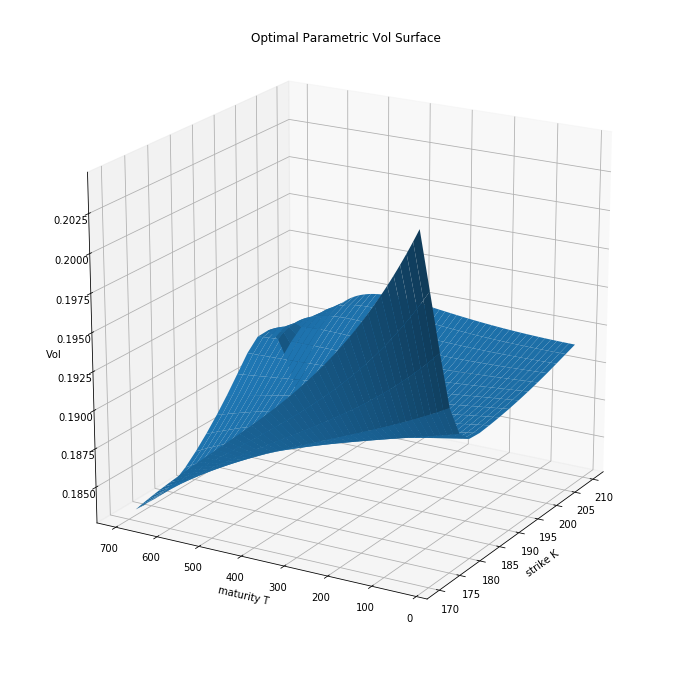

In [23]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,maturities/365, opt_param))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Vol')
plt.title('Optimal Parametric Vol Surface\n')
ax.view_init(20, 210)
plt.show()

**Append this surface to global chart with all 4 Volatility surfaces**

In [25]:
fig = py.get_figure('https://plot.ly/~friedrichz/674')
piv = go.Surface(x=strikes, y=maturities,z=vol_function(strikes,maturities/365, opt_param).tolist(), colorscale='Portland', showscale=False, opacity=0.7)

data = [ piv ]
py.plot(data, filename='4-Vol-Surfaces', fileopt='append')

'https://plot.ly/~friedrichz/674'

In [575]:
dataVOL = [go.Surface(x=strikes, y=maturities,z=bsSurface(opt_param, maturities, strikes, S).tolist(), colorscale='Viridis'),
           go.Surface(x=strikes, y=maturities,z=marketPrices.transpose().tolist(), colorscale='Portland', showscale=False, opacity=0.5)]

layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='AAPL Calls - Parametric Vol',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

fig = dict(data=dataVOL, layout=layout)
py.iplot(fig, filename='AAPL - Call Prices')

# All 4 Volatility Surfaces together can be found here:   https://plot.ly/~friedrichz/674/_4-volatility-surfaces/

# -- Testing --

In [578]:
dataVOL = [go.Surface(x=strikes, y=maturities,z=vol_function(strikes,maturities/365, opt_param).tolist(), colorscale='Viridis'),
           go.Surface(x=strikes, y=maturities,z=vol_function(strikes,maturities/365, initial_params_vol).tolist(), colorscale='Portland', showscale=False, opacity=0.5)]

layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='AAPL Calls - Parametric Vol Surface',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

fig = dict(data=dataVOL, layout=layout)
py.iplot(fig, filename='AAPL - Parametric Vol')

In [463]:
def plotSurface(strikes, maturities, Z1, Title, Filename):    
    dataVOL = [go.Surface(x=strikes, y=maturities,
        z=Z.tolist(), colorscale='Viridis')]
    layout = go.Layout(
        width=800,
        height=700,
        autosize=False,
        title=Title,
        scene=dict(
            xaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)',
                ticks='outside'
            ),
            yaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            zaxis=dict(
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict( x=1, y=1, z=0.7 ),
            aspectmode = 'manual'
        )
    )

    fig = dict(data=dataVOL, layout=layout)
    return py.iplot(fig, filename=Filename)

# -- Testing --

In [445]:
np.append(m, np.array([[7], [8], [9]]), axis=1)

array([[1, 2, 3, 7],
       [4, 5, 6, 8],
       [7, 8, 6, 9]])

In [82]:
para = [ 1.19105865e+01,  1.19034318e+01, -1.17372179e+00, -1.08516663e+01,
 -5.73804685e+00, -4.61398843e+01, -1.23706408e+01,  2.26988303e+01,
  1.62495234e+00,  3.79305507e+00,-1.78791463e+02, 4.87354761e+00, -1.80783877e+02, -1.70046167e-02]

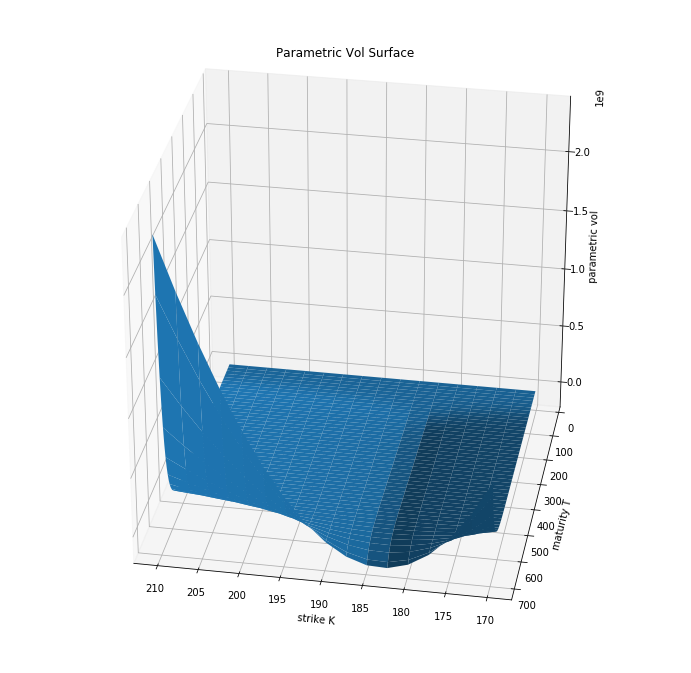

In [83]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,190,180,maturities/365, para))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
plt.title('Parametric Vol Surface')
ax.view_init(30, 100)
plt.show()

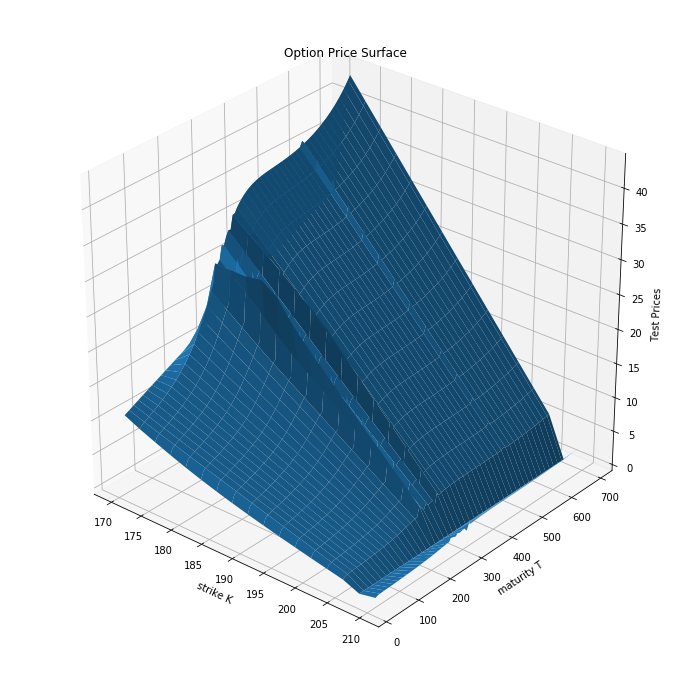

In [35]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, finite_diff(para, maturities, strikes, S, K0))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Test Prices')
plt.title('Option Price Surface')
ax.view_init(30, 310)
plt.show()

In [94]:
param = [ 1.19829640e+02, -5.15295763e+01,  2.10913139e+00, -2.74157389e+02,
 -5.15279846e+01 , 1.35424287e+02 ,-5.39033429e+02 , 3.10258228e+02,
 -5.27814768e+01 , 1.03549872e+02 , 1.51855566e+05 , 7.16231156e-02,
 -4.24795221e+03, -4.34376895e-02]

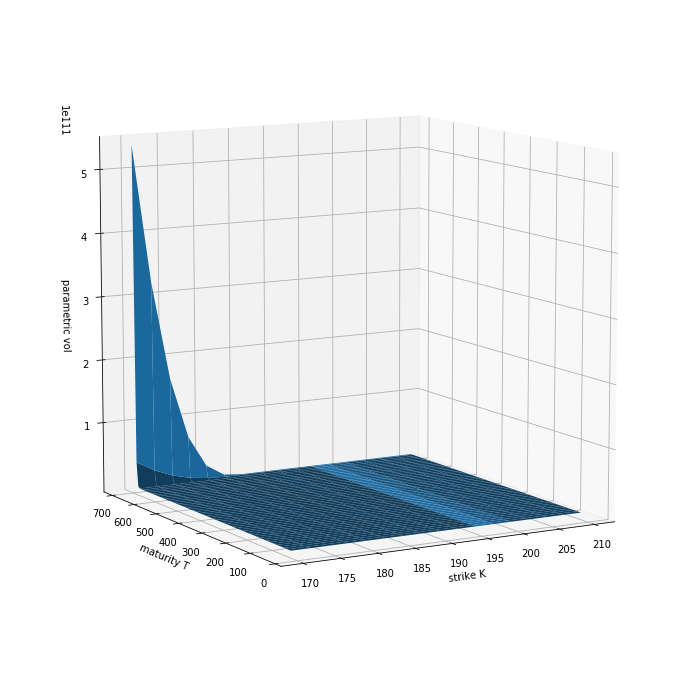

In [101]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,maturities/365, param))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
ax.view_init(10, 240)
plt.show()

#### Finite Differences Testing

In [ ]:
testPrices = finite_diff(initial_params_vol, maturities, strikes, S, K0)

In [ ]:
def forwardPDE():    
    boundary = 'neumann'
    #boundary = 'dirichlet'

    r = 0.0541
    q = 0.012

    S = 180
    K = 190

    sig = 0.3
    T = 1

    # 0,1,2,...,N,N+1

    sMin = 100
    sMax = 2000

    N = 1000
    M = 365

    dS = (sMax - sMin) / N
    dT = T / M

    s = np.zeros(N-1)
    tau = np.zeros(M)

    l = np.zeros(N-1)
    u = np.zeros(N-1)
    d = np.zeros(N-1)

    vCall = np.zeros(N-1)
    vPut = np.zeros(N-1)

    alpha = 0.5 * (sig ** 2) * dT / (dS ** 2)
    beta = (r - q) * dT / (2.0 * dS)

    # tridiagonal matrix
    s = sMin + np.arange(1, N) * dS
    l = -alpha * (s ** 2) + beta * s
    l[0] = 0
    d = 1 + r * dT + 2 * alpha * (s ** 2)
    u = -alpha * (s ** 2) - beta * s
    u[-1] = 0

    if boundary == 'neumann':
        l[-1] = 2 * beta * s[-1]
        d[0] = 1 + r * dT + 2 * beta * s[0]
        d[-1] = 1 + r * dT - 2 * beta * s[-1]
        u[0] = -2 * beta * s[0]

    tau = dT * np.arange(1, M+1)
    
    vCall = np.maximum(s - K, 0)
    for j in range(M):
        # print progress
        if (j+1) % 50 == 0:
            print('iter = ' + str(j+1))
        ######################
        # calls
        if boundary == 'dirichlet':
            tmp_pay = sMax*np.exp(-r*dT*j) - K*np.exp(-q*dT*j)
            vCall[-1] -= tmp_pay * (-alpha * (sMax ** 2) - beta * sMax)
        vCall = tridiagSolver(l, d, u, vCall)
    return 

In [423]:
from scipy.stats import norm
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

def bsSurface(params_vol, maturities, strikes, S):
    r = 0.0541
    q = 0.012
    maturities_years = maturities/365
    vol = vol_function(strikes,maturities_years,params_vol)
    lenT = len(maturities)
    lenK = len(strikes)
    bsPrices = np.zeros((lenT, lenK))
    if bsPrices.shape != vol.shape:
        print('Shape missmatch')
    else:
        for i in range(lenT):
            for j in range(lenK):
                T = maturities_years[i]
                K = strikes[j]
                sig = vol[i,j]
                bsPrices[i,j] = BS_price('call',S,K,r,q,sig,T)
    return bsPrices

In [438]:
BS_price('call', S, 190, r, q, 0.24, 2)

32.20399715029542

In [194]:
np.maximum(np.arange(1, 10) - 5,0)

array([0, 0, 0, 0, 0, 1, 2, 3, 4])

In [ ]:
(params_vol, maturities, strikes, S, K0):
    r = 0.0541
    q = 0.012

In [425]:
def bsSurface(params_vol, maturities, strikes, S):
    r = 0.0541
    q = 0.012
    maturities_years = maturities/365
    vol = vol_function(strikes,maturities_years,params_vol)
    lenT = len(maturities)
    lenK = len(strikes)
    bsPrices = np.zeros((lenT, lenK))
    if bsPrices.shape != vol.shape:
        print('Shape missmatch')
    else:
        for i in range(lenT):
            for j in range(lenK):
                T = maturities_years[i]
                K = strikes[j]
                sig = vol[i,j]
                bsPrices[i,j] = BS_price('call',S,K,r,q,sig,T)
    return bsPrices

In [437]:
bsSurface(initial_params_vol, maturities, strikes, S)

array([[41.18560058, 37.31336646, 32.08541592, ...,  2.40057086,
         3.52943236,  3.94377367],
       [44.6785563 , 40.54511735, 34.88814317, ...,  3.15189587,
         4.53561142,  5.0726111 ],
       [47.72008129, 43.3612017 , 37.33565452, ...,  3.85179403,
         5.45994544,  6.10939554],
       ...,
       [80.79609783, 74.69847055, 66.26615282, ..., 21.33353632,
        24.97828118, 27.21055357],
       [80.65649368, 74.57521985, 66.1753076 , ..., 21.40181338,
        25.02563281, 27.25008863],
       [80.51532092, 74.45054876, 66.08323413, ..., 21.46956968,
        25.07227994, 27.28874557]])

In [ ]:
vol_function(k,[t],params_vol)[0]

In [ ]:
    maturities_years = maturities/365
    T = maturities_years[-1]
    
    # 0,1,2,...,N,N+1
    kMin = min(strikes)
    kMax = max(strikes)

    N = len(strikes)-1  # There is one "Box" less than number of strikes on x-Axis
    M = len(maturities) #96

    dK = (kMax - kMin) / (len(strikes)-1) # 2.5
    dT = 7/365                            

    # Need to switch the fixed parameters now: S becomes fixed & K is my x-axis ==> LEAVE OUT BOUNDARIES
    k = strikes[1:-1]
    tau = maturities_years

    l = np.zeros(N-1)    # Lenght is 15 -> not including boundaries!
    u = np.zeros(N-1)
    d = np.zeros(N-1)
    
    vCall = np.zeros(N-1)
    
    alpha = 0.5 * dT / (dK ** 2)     # taking (sig ** 2) out because different on each T;K grid point 
    beta = (r - q) * dT / (2.0 * dK)
 
    vCall = np.maximum(S - k,0)   # Initial condition -> Risk-neutral pricing / Excl. Boundaries !!
    modelPrices = np.zeros((len(tau), len(strikes)))
    vCall_wB = np.insert(vCall,0,S-kMax)
    vCall_wB = np.append(vCall_wB,S-kMin)
    modelPrices[0] = vCall_wB       # Init Cond at tau = 0
    # For each time slice compute Option Prices via Implicit scheme across all strikes (as opposed to stock prices)
    # And with vol function with fixed T across all strikes -> time slice 2 dim
    # Reference point is x_j,i+1 -> thus need sig_j,i+1 at each point (!)
    for j in range(M):
        t = tau[j]                                                              # The only diff to before is that now sigma is dependend on maturity and strike, thus I need to update the tridiagonal matrix in each run   
        # tridiagonal matrix: Need to do Dirichlet                              # Thus calc vol for all strikes and fixed maturity   
        l = (-alpha * (k ** 2) * vol_function(k,[t],params_vol)[0] + beta * k)  # implicit scheme l_hat -> already setting up the entire(!) diagonal
        l[0] = 0                                                                        # l & u are by one row shorter than d
        d = (1 + r * dT + 2 * alpha*vol_function(k,[t],params_vol)[0] * (k ** 2))  # because output of vol_function is matrix
        u = (-alpha*vol_function(k,[t],params_vol)[0] * (k ** 2) - beta * k)
        u[-1] = 0
        
        tmp_pay_Max = np.maximum(S - kMax*np.exp(-r*t),0)                    # Because under R-N measure PV & EV of Stock cancel out
        vCall[-1] -= tmp_pay_Max * (-alpha * vol_function([kMax],[t],params_vol)[0] * (kMax ** 2) - beta * kMax)   
        
        tmp_pay_Min = np.maximum(S - kMin*np.exp(-r*t),0)
        vCall[0] -= tmp_pay_Min * (-alpha * vol_function([kMin],[t],params_vol)[0] * (kMin ** 2) + beta * kMin)
        
        vCall = tridiagSolver(l, d, u, vCall)    # solve for vk+1´s in current time slice for european options
        vCall_wB = np.insert(vCall,0,tmp_pay_Min)
        vCall_wB = np.insert(vCall_wB,-1,tmp_pay_Max)
        modelPrices[j] = vCall_wB
        #modelPrices[j].append(np.maximum(S - kMax*np.exp(-q*dT*j),0))
        #print(modelPrices[j])
    return modelPrices[5:,1:-2]

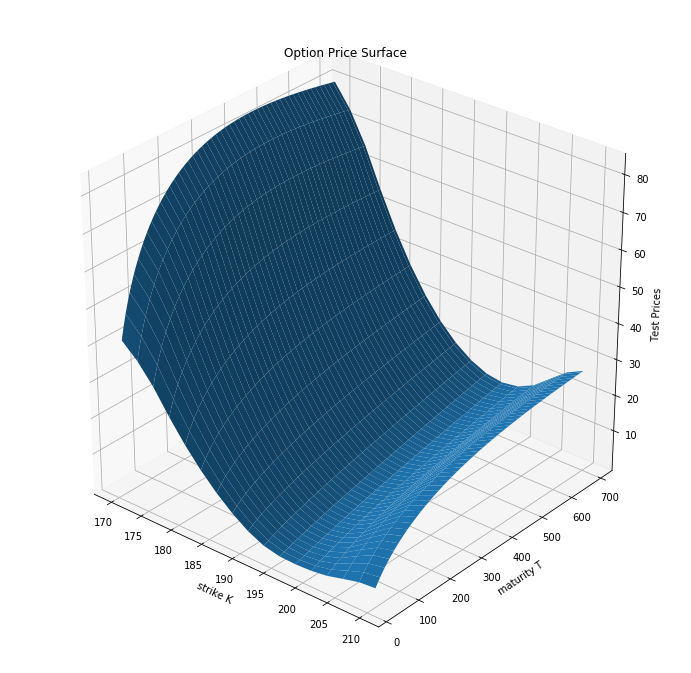

In [407]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, bsSurface(initial_params_vol, maturities, strikes, S))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Test Prices')
plt.title('Option Price Surface')
ax.view_init(30, 310)
plt.show()

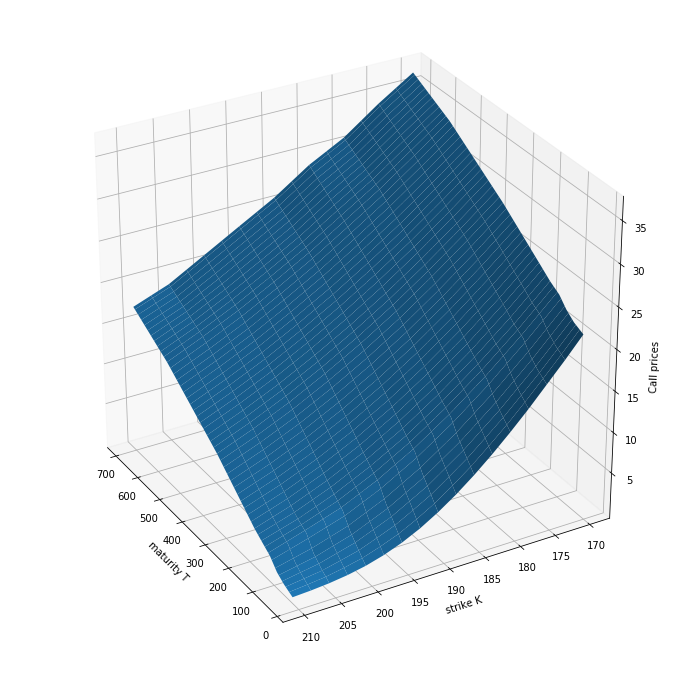

In [568]:
maturities, strikes, marketPrices = marketSurface.readNPlot('APPL', 'Call')
maturities_years = maturities/365

In [569]:
marketPrices.shape

(17, 96)

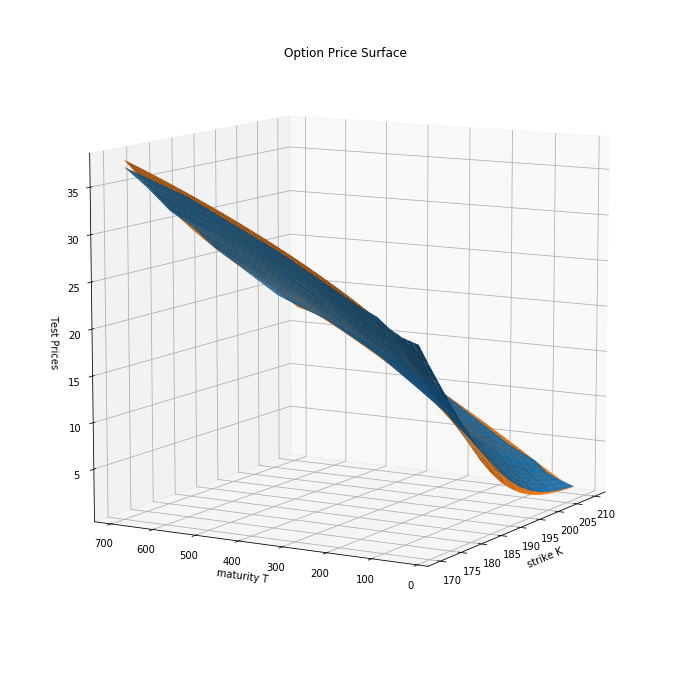

In [573]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, marketPrices.transpose())
ax.plot_surface(X, Y, bsSurface(opt_param, maturities, strikes, S))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('Test Prices')
plt.title('Option Price Surface')
ax.view_init(10, 210)
plt.show()

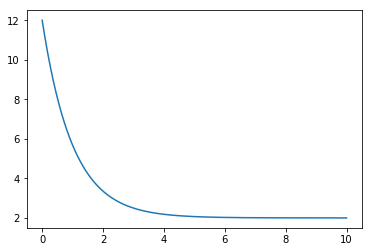

In [9]:
x = np.linspace(0,10,1000)
plt.plot(x, 2+10*1/np.exp(x))